# **PORTFOLIO OPTIMIZATION**

# **1.0 INTRODUCTION**
The aim of this project is to utilise ***reinforcement learning*** to train a machine to learn how to rebalance a portfolio of stocks given what happened prior in the market. For this project, our portfilio will initially focus on the ***Dow Jones Index*** of **30 constituents**.

## **1.1 Import Dependencies**

In [1]:
import yfinance as yf
import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import seaborn as sns
from functools import reduce
import numpy as np
%matplotlib inline
sns.set_style('darkgrid')
plt.style.use('fivethirtyeight')

In [ ]:
import os
from finrl import config
from finrl import config_tickers

if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

## **1.2 Data Collection & Cleaning**
We'll select the stocks from the DOW JONES for our analysis.

In [2]:
DOW_30_TICKERS = [
    "AXP",
    "AMGN",
    "AAPL",
    "BA",
    "CAT",
    "CSCO",
    "CVX",
    "GS",
    "HD",
    "HON",
    "IBM",
    "INTC", 
    "JNJ",
    "KO",
    "JPM",
    "MCD",
    "MMM",
    "MRK",
    "MSFT",
    "NKE",
    "PG",
    "TRV",
    "UNH",
    "CRM",
    "VZ",
    "V",
    "WBA",
    "WMT",
    "DIS",
    "DOW"
]

We'll make dictionaries for each ticker and store financial data within them. 
<br><br>
We'll focus on ticker name, the yahoo finance object, info and historical prices over the past ***10 years***.
<br><br>
For each ticker, the financial information will be represented by a dataframe.


In [3]:
DOW_tickers_data = []
for ticker in DOW_30_TICKERS:
    ticker_dict = {
                   'ticker': ticker, 
                   'info': yf.Ticker(ticker).info,
                   'daily_prices':yf.download(ticker, period = '10y', interval = '1d')
                   }
    DOW_tickers_data.append(ticker_dict)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Here is an example of one of historical data for one of our constituents.

In [4]:
DOW_tickers_data[0]['daily_prices'].head()

Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2012-04-23  56.959999  57.389999  56.500000  57.320000  49.687771   6168200
2012-04-24  57.240002  57.759998  57.090000  57.630001  49.956505   5401100
2012-04-25  57.939999  59.000000  57.830002  58.910000  51.066067   8184700
2012-04-26  58.849998  59.720001  58.750000  59.590000  51.655514   6168400
2012-04-27  59.849998  60.959999  59.830002  60.169998  52.158287  13975100

We'll now make a few changes to our dataframes.

In [5]:
# assign a column order for our dataframes
column_order = ['date', 'open', 'high', 'low', 'close', 'adjcp', 'volume',	'tic', 'day']

for ticker in DOW_tickers_data:
    # make the index a datetime object
    ticker['daily_prices'] = ticker['daily_prices'].reset_index()
    ticker['daily_prices'] = ticker['daily_prices'].rename({'Date': 'date'}, axis = 1)
    ticker['daily_prices']['date'] = pd.to_datetime(ticker['daily_prices']['date'])
    # add a column for 'day of the week'
    ticker['daily_prices']['day'] = ticker['daily_prices']['date'].dt.dayofweek
    # add the ticker name to the dataframe
    ticker['daily_prices']['tic'] = ticker['ticker']
    # rename the adjusted closing price column
    ticker['daily_prices'] = ticker['daily_prices'].rename({'Adj Close': 'adjcp'}, axis = 1)
    # set a column order for our dataframes
    ticker['daily_prices'].columns = ticker['daily_prices'].columns.str.lower()
    ticker['daily_prices'] = ticker['daily_prices'][column_order]
    # convert date column back to str
    ticker['daily_prices']['date'] = ticker['daily_prices']['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

In [6]:
DOW_tickers_data[0]['daily_prices']

date        open        high         low       close       adjcp  \
0     2012-04-23   56.959999   57.389999   56.500000   57.320000   49.687771   
1     2012-04-24   57.240002   57.759998   57.090000   57.630001   49.956505   
2     2012-04-25   57.939999   59.000000   57.830002   58.910000   51.066067   
3     2012-04-26   58.849998   59.720001   58.750000   59.590000   51.655514   
4     2012-04-27   59.849998   60.959999   59.830002   60.169998   52.158287   
...          ...         ...         ...         ...         ...         ...   
2513  2022-04-18  181.330002  185.889999  181.000000  184.479996  184.479996   
2514  2022-04-19  185.009995  188.089996  184.710007  187.169998  187.169998   
2515  2022-04-20  188.330002  190.149994  187.639999  188.460007  188.460007   
2516  2022-04-21  190.940002  192.419998  184.580002  185.740005  185.740005   
2517  2022-04-22  185.429993  185.550003  180.320007  180.539993  180.539993   

        volume  tic  day  
0      6168200  AXP    0  
1      5401100  AXP    1  
2      8184700  AXP    2  
3      6168400  AXP    3  
4     13975100  AXP    4  
...        ...  ...  ...  
2513   2182700  AXP    0  
2514   2713800  AXP    1  
2515   2256200  AXP    2  
2516   3973200  AXP    3  
2517   4373200  AXP    4  

[2518 rows x 9 columns]

We'll now compile a list of the historical prices dataframes so we can create a ***panel dataset***.

In [7]:
DOW_tickers_prices = [ticker['daily_prices'] for ticker in DOW_tickers_data]

# And then compile them into a single dataframe
DOW_tickers_panel_dataset = pd.concat(DOW_tickers_prices)
DOW_tickers_panel_dataset = DOW_tickers_panel_dataset[column_order]
DOW_tickers_panel_dataset.head()

date       open       high        low      close      adjcp  \
0  2012-04-23  56.959999  57.389999  56.500000  57.320000  49.687771   
1  2012-04-24  57.240002  57.759998  57.090000  57.630001  49.956505   
2  2012-04-25  57.939999  59.000000  57.830002  58.910000  51.066067   
3  2012-04-26  58.849998  59.720001  58.750000  59.590000  51.655514   
4  2012-04-27  59.849998  60.959999  59.830002  60.169998  52.158287   

     volume  tic  day  
0   6168200  AXP    0  
1   5401100  AXP    1  
2   8184700  AXP    2  
3   6168400  AXP    3  
4  13975100  AXP    4

In [ ]:
DOW_tickers_panel_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73730 entries, 0 to 761
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    73730 non-null  object 
 1   open    73729 non-null  float64
 2   high    73729 non-null  float64
 3   low     73729 non-null  float64
 4   close   73729 non-null  float64
 5   adjcp   73729 non-null  float64
 6   volume  73729 non-null  float64
 7   tic     73730 non-null  object 
 8   day     73730 non-null  int64  
dtypes: float64(6), int64(1), object(2)
memory usage: 5.6+ MB


We'll have a look to see if there are any na values.

In [8]:
DOW_tickers_panel_dataset[pd.isna(DOW_tickers_panel_dataset['open'])]

Empty DataFrame
Columns: [date, open, high, low, close, adjcp, volume, tic, day]
Index: []

What we need to also check is how many tickers have a full set of values we have for unique date.

In [9]:
DOW_tickers_panel_dataset.groupby('date').count().sort_values(by = 'tic')

open  high  low  close  adjcp  volume  tic  day
date                                                       
2012-04-23     5     5    5      5      5       5    5    5
2016-12-06    29    29   29     29     29      29   29   29
2016-12-05    29    29   29     29     29      29   29   29
2016-12-02    29    29   29     29     29      29   29   29
2016-12-01    29    29   29     29     29      29   29   29
...          ...   ...  ...    ...    ...     ...  ...  ...
2020-04-03    30    30   30     30     30      30   30   30
2020-04-06    30    30   30     30     30      30   30   30
2020-04-07    30    30   30     30     30      30   30   30
2020-03-06    30    30   30     30     30      30   30   30
2022-04-22    30    30   30     30     30      30   30   30

[2518 rows x 8 columns]

Oddly, we see there are 5 tickers that have values on the ***23rd of April 2012***. <br><br>
We'll need to drop these records as our algorithm won't work with this dataset.

In [10]:
DOW_tickers_panel_dataset = DOW_tickers_panel_dataset[DOW_tickers_panel_dataset['date'] != '2012-04-23']
DOW_tickers_panel_dataset

date       open       high        low      close      adjcp  \
1    2012-04-24  57.240002  57.759998  57.090000  57.630001  49.956505   
2    2012-04-25  57.939999  59.000000  57.830002  58.910000  51.066067   
3    2012-04-26  58.849998  59.720001  58.750000  59.590000  51.655514   
4    2012-04-27  59.849998  60.959999  59.830002  60.169998  52.158287   
5    2012-04-30  60.049999  60.310001  59.750000  60.209999  52.192970   
..          ...        ...        ...        ...        ...        ...   
776  2022-04-18  65.489998  66.480003  65.300003  65.879997  65.879997   
777  2022-04-19  66.029999  67.349998  65.910004  67.050003  67.050003   
778  2022-04-20  67.070000  68.169998  67.040001  67.540001  67.540001   
779  2022-04-21  69.000000  71.860001  68.889999  69.510002  69.510002   
780  2022-04-22  70.070000  71.230003  68.239998  68.500000  68.500000   

       volume  tic  day  
1     5401100  AXP    1  
2     8184700  AXP    2  
3     6168400  AXP    3  
4    13975100  AXP    4  
5     7902500  AXP    0  
..        ...  ...  ...  
776   4958900  DOW    0  
777   5292500  DOW    1  
778   5021500  DOW    2  
779  10282500  DOW    3  
780   7437800  DOW    4  

[73774 rows x 9 columns]

So our panel dataset has over 73,000 rows with 9 columns and one of those columns includes the ticker name.
<br><br>
We'll now export this dataframe into a csv.

In [11]:
DOW_tickers_panel_dataset = DOW_tickers_panel_dataset.reset_index().drop('index', axis = 1)
DOW_tickers_panel_dataset.to_csv('data/DOW_tickers_panel_dataset.csv', index=True)

In [12]:
DOW_tickers_panel_dataset = pd.read_csv('data/DOW_tickers_panel_dataset.csv').drop('Unnamed: 0', axis = 1)

## **1.3 EDA**
With our panel dataset created, we can now perform simple EDA and data visualisations.

We can visualise the median changes in price across the years.

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f0525be68c0> (for post_execute):


KeyboardInterrupt: ignored

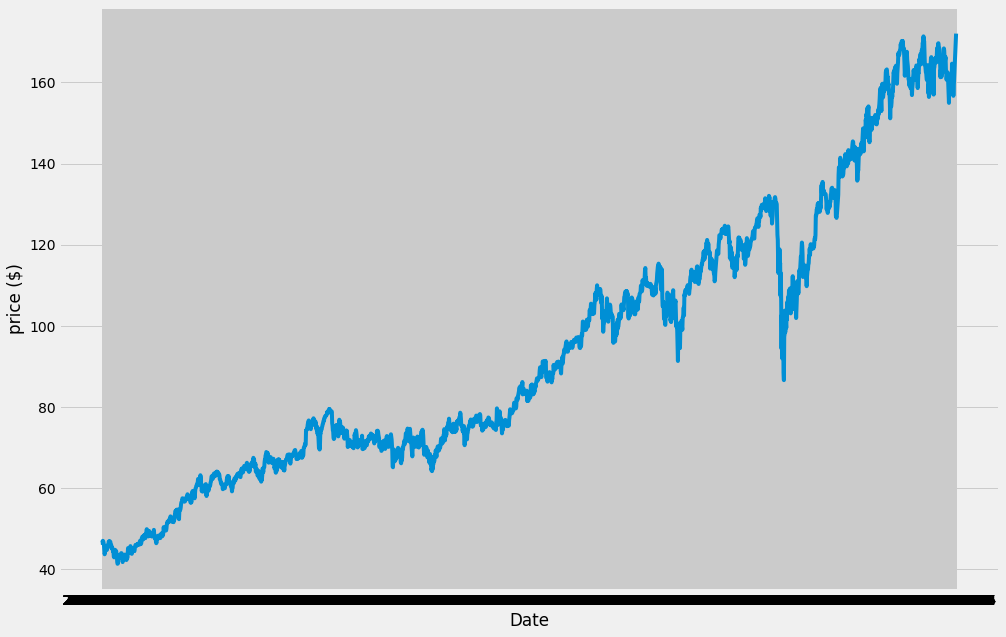

In [ ]:
median_panel_dataset = DOW_tickers_panel_dataset.groupby('date').median().reset_index()

fig, ax = plt.subplots(figsize = (15, 10))
ax = sns.lineplot(data = median_panel_dataset, 
                    x = 'date',
                    y = 'adjcp')
ax.set_ylabel('price ($)')
ax.set_xlabel('Date');

A more important metric would be viewing average ***ROI***.
<br><br>
We'll firstly calculate it per ticker.

In [13]:
ROI_df_list = []

for ticker in DOW_30_TICKERS:
    df = DOW_tickers_panel_dataset[DOW_tickers_panel_dataset['tic'] == ticker]
    df['ROI'] = df['adjcp'].pct_change()
    df = df.dropna()
    ROI_df_list.append(df)

<ipython-input-13-ff256604bbcb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ROI'] = df['adjcp'].pct_change()
<ipython-input-13-ff256604bbcb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ROI'] = df['adjcp'].pct_change()
<ipython-input-13-ff256604bbcb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

We'll then turn list of dataframes into a single panel set and calculate the median ROI.

In [14]:
ROI_panel = pd.concat(ROI_df_list)
median_ROI_panel = ROI_panel.groupby('date').median().reset_index()

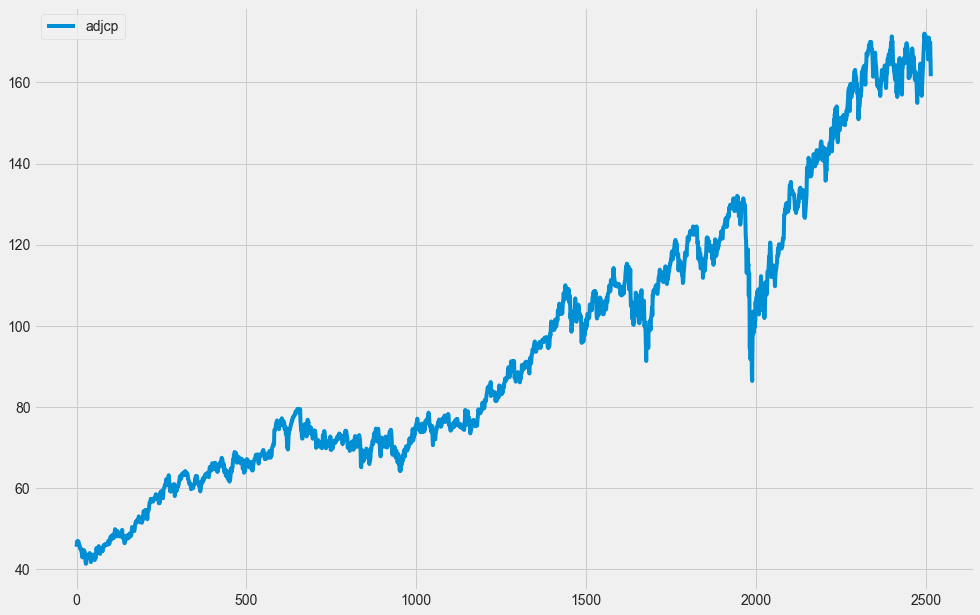

In [15]:
median_ROI_panel[['date', 'adjcp']].plot(figsize = (15, 10));

The median ROI is relatively stable throughout the 10 years apart from around early 2020 due to covid and lockdown rules.
<br><br>
What we can do now is look at the top performing tickers over a range of time periods:
- ***1 month***
- ***6 month***
- ***1 year***

In [16]:
ROI_list = []

for ticker in DOW_30_TICKERS:
    df = DOW_tickers_panel_dataset[DOW_tickers_panel_dataset['tic'] == ticker]
    # we'll take the prior values for each time period
    month_1_prior = df.iloc[-22]['adjcp']
    month_6_prior = df.iloc[-(22 * 6)]['adjcp']
    year_1_prior = df.iloc[-(22 * 12)]['adjcp']
    current_value = df.iloc[-1]['adjcp']
    # now we'll calculate the ROIs
    month_1_ROI = ((100 / month_1_prior) * current_value) - 100
    month_6_ROI = ((100 / month_6_prior) * current_value) - 100
    year_1_ROI = ((100 / year_1_prior) * current_value) - 100

    summary_dict = {'ticker': ticker,
                    'month_1_ROI': month_1_ROI, 
                    'month_6_ROI': month_6_ROI,
                    'year_1_ROI': year_1_ROI}

    ROI_list.append(summary_dict)

In [17]:
ROI_df = pd.DataFrame(ROI_list)
ROI_df.head()

ticker  month_1_ROI  month_6_ROI  year_1_ROI
0    AXP    -2.670431     5.828749   24.070239
1   AMGN     6.904951    23.133981    4.660841
2   AAPL    -4.946838    12.849581   24.847800
3     BA    -4.902169   -18.635028  -30.606001
4    CAT    -2.175225    13.002500   -3.777246

**1 month ROI**

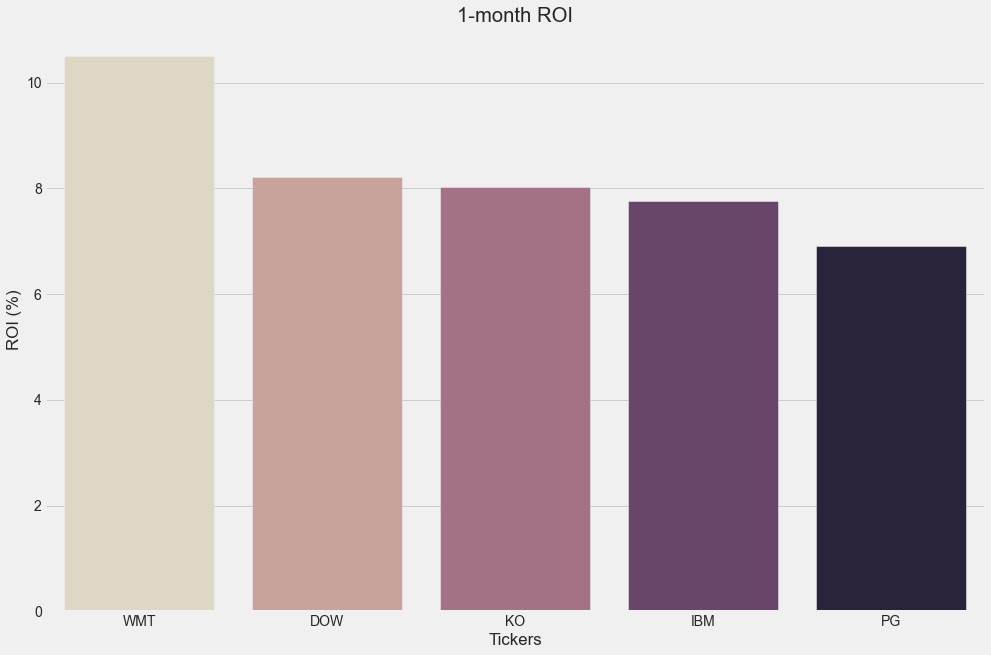

In [18]:
fig, ax = plt.subplots(figsize = (15, 10))
month_1_ROI_df = ROI_df[['ticker', 'month_1_ROI']].sort_values('month_1_ROI', ascending = False).head()
ax = sns.barplot(data = month_1_ROI_df, 
                x = 'ticker', 
                y = 'month_1_ROI',
                palette = sns.color_palette('ch:s=-.2,r=.6', n_colors=5))
ax.set_title('1-month ROI')
ax.set_ylabel('ROI (%)')
ax.set_xlabel('Tickers');

**6 month ROI**

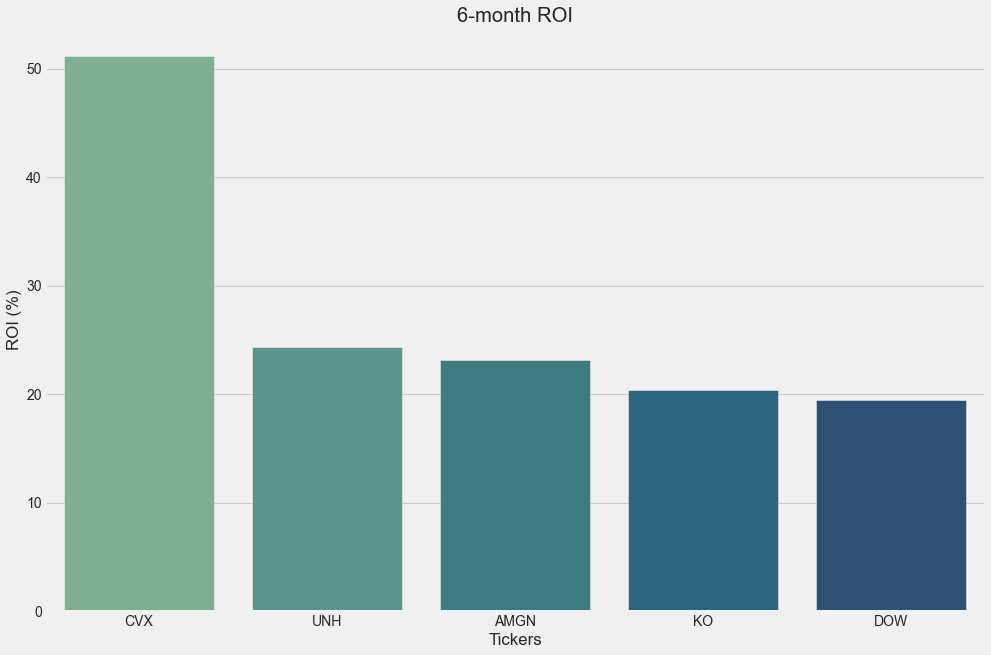

In [19]:
fig, ax = plt.subplots(figsize = (15, 10))
month_6_ROI_df = ROI_df[['ticker', 'month_6_ROI']].sort_values('month_6_ROI', ascending = False).head()
ax = sns.barplot(data = month_6_ROI_df, 
                x = 'ticker', 
                y = 'month_6_ROI',
                palette = sns.color_palette('crest', n_colors=5))
ax.set_title('6-month ROI')
ax.set_ylabel('ROI (%)')
ax.set_xlabel('Tickers');

**1 year ROI**

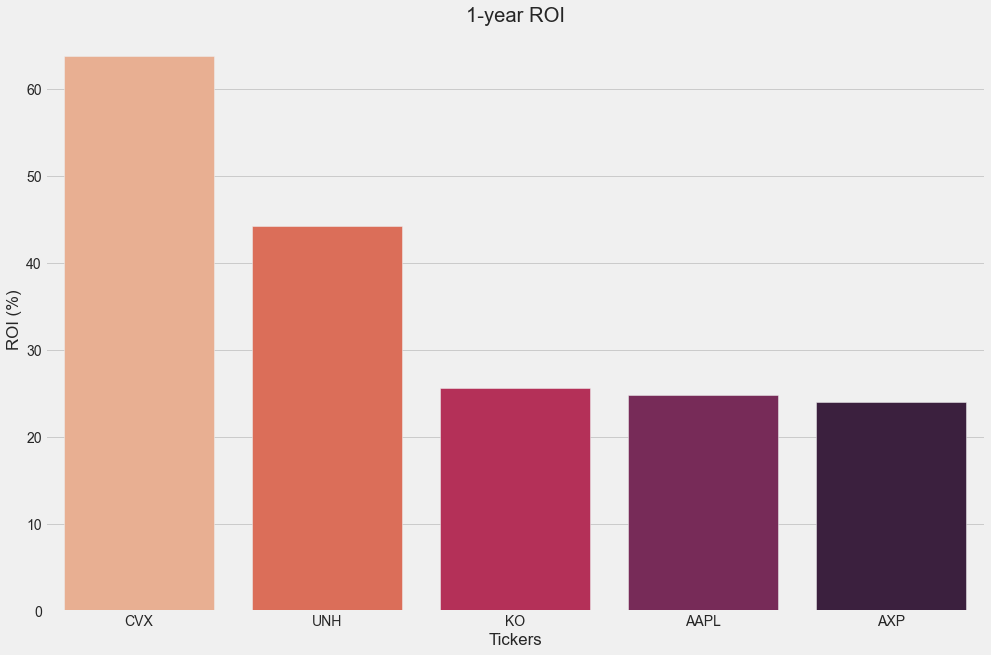

In [20]:
fig, ax = plt.subplots(figsize = (15, 10))
year_1_ROI_df = ROI_df[['ticker', 'year_1_ROI']].sort_values('year_1_ROI', ascending = False).head()
ax = sns.barplot(data = year_1_ROI_df, 
                x = 'ticker', 
                y = 'year_1_ROI', 
                palette = sns.color_palette('rocket_r', n_colors=5))
ax.set_title('1-year ROI')
ax.set_ylabel('ROI (%)')
ax.set_xlabel('Tickers');

Interestingly, we see the same ***CVX*** stock appear as the top performing stocks in each time period.

# **2.0 Data Preparation**

## **2.1 Feature Engineering**
For our feature engineering, we'll be focusing on ***technical indicators*** that focus on these categories:
<br>
- ***Trends***<br>
- ***Momentum***<br>
- ***Volume***<br>

We'll firstly import our dependencies which all come from the ***finrl*** library.

In [21]:
from finrl.apps import config_tickers
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts
from finrl.finrl_meta.data_processor import DataProcessor
from finrl.finrl_meta.data_processors.processor_yahoofinance import YahooFinanceProcessor

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


The first step is to do a general preprocessing of our data. We'll incorporate finrl's in built preprocessor for this.

In [22]:
DOW_tickers_panel_dataset_processed = FeatureEngineer(use_technical_indicator = True, use_turbulence = True).preprocess_data(DOW_tickers_panel_dataset)

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\finrl\finrl_meta\preprocessor\preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\finrl\finrl_meta\preprocessor\preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\finrl\finrl_meta\preprocessor\preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\finrl\finrl_meta\preprocessor\preprocessors.py:154: FutureWarning: The frame.append method is d

Successfully added technical indicators
Successfully added turbulence index


In [24]:
DOW_tickers_panel_dataset_processed.head()

date        open        high         low       close      adjcp  \
0  2012-04-24   20.093214   20.274643   19.821428   20.010000  17.134048   
1  2012-04-24   68.419998   69.099998   68.360001   68.629997  53.451557   
2  2012-04-24   57.240002   57.759998   57.090000   57.630001  49.956505   
3  2012-04-24   73.209999   73.739998   72.769997   73.209999  60.257221   
4  2012-04-24  107.250000  108.790001  107.099998  108.400002  81.787010   

       volume   tic  day  macd    boll_ub    boll_lb  rsi_30     cci_30  \
0  1076149200  AAPL    1   0.0  23.409094  18.386619   100.0  66.666667   
1     4906100  AMGN    1   0.0  23.409094  18.386619   100.0  66.666667   
2     5401100   AXP    1   0.0  23.409094  18.386619   100.0  66.666667   
3     3664500    BA    1   0.0  23.409094  18.386619   100.0  66.666667   
4     5703200   CAT    1   0.0  23.409094  18.386619   100.0  66.666667   

   dx_30  close_30_sma  close_60_sma  turbulence  
0  100.0     20.010000     20.010000         0.0  
1  100.0     68.629997     68.629997         0.0  
2  100.0     57.630001     57.630001         0.0  
3  100.0     73.209999     73.209999         0.0  
4  100.0    108.400002    108.400002         0.0

Whilst the preprocessing added a few technical indicators e.g. **SMA** and **RSI**, we'll now add a few more to our dataset.

In [33]:
from ta.volatility import BollingerBands
from ta.trend import SMAIndicator, MACD, CCIIndicator, EMAIndicator, IchimokuIndicator, AroonIndicator
from ta.momentum import RSIIndicator, stoch, WilliamsRIndicator
from ta.volume import OnBalanceVolumeIndicator, MFIIndicator

In [34]:
df_list = []
for tic in DOW_tickers_panel_dataset_processed.tic.unique():
    df = DOW_tickers_panel_dataset_processed[DOW_tickers_panel_dataset_processed['tic'] == tic]
    #Log returns
    df['log_return'] = np.log(df['adjcp'] / df['adjcp'].shift(1))
    # CCI
    _cci = CCIIndicator(high = df['high'],
                        low = df['low'], 
                        close = df['close'],
                        window = 20)
    df['20_day_CCI'] = _cci.cci()
    # Ichimoku Indicator
    ichi = IchimokuIndicator(high = df['high'],
                             low = df['low'])
                             
    df['ichimoku_span_a'] = ichi.ichimoku_a()
    df['ichimoku_span_b'] = ichi.ichimoku_b()
    df['ichimoku_span_baseline'] = ichi.ichimoku_base_line()
    df['ichimoku_span_conversion_line'] = ichi.ichimoku_conversion_line()
    # ArronIndicator
    _aroon = AroonIndicator(close = df['close'])
    df['Aroon_down'] = _aroon.aroon_down()
    df['Aroon_up'] = _aroon.aroon_up()
    df['Aroon_indicator'] = _aroon.aroon_indicator()
    #Williams R Indicator
    df['wiilliams_r'] = WilliamsRIndicator(high = df['high'],
                                            low = df['low'],
                                            close = df['close']
                                            ).williams_r()
    # On Balance Volume
    df['on_balance_volume'] = OnBalanceVolumeIndicator(close = df['close'],
                                                        volume = df['volume']
                                                        ).on_balance_volume()
    #MFI
    df['mfi'] = MFIIndicator(high = df['high'],
                            low = df['low'],
                            close = df['close'],
                            volume = df['volume']
                            ).money_flow_index()

    df_list.append(df)

We'll now concatenate the list of dataframes into a single dataframe.

In [35]:
DJIA = pd.concat(df_list)
DJIA

date        open        high         low       close       adjcp  \
0      2012-04-24   20.093214   20.274643   19.821428   20.010000   17.134048   
29     2012-04-25   21.987143   22.071428   21.642857   21.785713   18.654541   
58     2012-04-26   21.938213   21.953215   21.504642   21.703571   18.584209   
87     2012-04-27   21.609644   21.649286   21.446428   21.535713   18.440475   
116    2012-04-30   21.350000   21.371429   20.821428   20.856428   17.858820   
...           ...         ...         ...         ...         ...         ...   
72876  2022-04-18  156.750000  157.979996  155.210007  155.880005  155.880005   
72905  2022-04-19  156.669998  157.949997  156.039993  157.649994  157.649994   
72934  2022-04-20  158.350006  160.350006  158.289993  159.630005  159.630005   
72963  2022-04-21  159.919998  160.770004  159.070007  159.869995  159.869995   
72992  2022-04-22  160.250000  160.360001  156.660004  156.860001  156.860001   

           volume   tic  day      macd  ...  ichimoku_span_a  ichimoku_span_b  \
0      1076149200  AAPL    1  0.000000  ...              NaN        20.048036   
29      905777600  AAPL    2  0.039840  ...              NaN        20.946428   
58      536068400  AAPL    3  0.048216  ...              NaN        20.946428   
87      406722400  AAPL    4  0.044784  ...              NaN        20.946428   
116     506144800  AAPL    0  0.014946  ...              NaN        20.946428   
...           ...   ...  ...       ...  ...              ...              ...   
72876     4890600   WMT    0  3.807815  ...       152.210003       145.209999   
72905     5285000   WMT    1  3.834593  ...       152.210003       145.209999   
72934     6607200   WMT    2  3.969824  ...       153.692505       146.180000   
72963     6056100   WMT    3  4.049679  ...       153.902504       146.389999   
72992     7013100   WMT    4  3.825979  ...       153.902504       146.389999   

       ichimoku_span_baseline  ichimoku_span_conversion_line  Aroon_down  \
0                         NaN                            NaN         NaN   
29                        NaN                            NaN         NaN   
58                        NaN                            NaN         NaN   
87                        NaN                            NaN         NaN   
116                       NaN                            NaN         NaN   
...                       ...                            ...         ...   
72876              149.965004                     154.455002        32.0   
72905              149.965004                     154.455002        28.0   
72934              150.935005                     156.450005        24.0   
72963              151.145004                     156.660004        20.0   
72992              151.145004                     156.660004        16.0   

       Aroon_up  Aroon_indicator  wiilliams_r  on_balance_volume        mfi  
0           NaN              NaN          NaN         1076149200        NaN  
29          NaN              NaN          NaN         1981926800        NaN  
58          NaN              NaN          NaN         1445858400        NaN  
87          NaN              NaN          NaN         1039136000        NaN  
116         NaN              NaN          NaN          532991200        NaN  
...         ...              ...          ...                ...        ...  
72876      80.0             48.0   -20.805905          253701800  79.931335  
72905     100.0             72.0    -6.684337          258986800  79.756273  
72934     100.0             76.0    -5.916191          265594000  79.528005  
72963     100.0             80.0    -7.544078          271650100  79.047486  
72992      96.0             80.0   -36.576265          264637000  72.351722  

[72993 rows x 30 columns]

## **2.2 Forming our covariance matrix**
For our RL model to work, we are required to feed in a **covariance matrix** of stock returns for each date for each ticker. This is so we can view the correlation of prices between tickers.<br><br>
The covariance matrix will be based on values **one year** into the past.

In [36]:
DJIA = DJIA.sort_values(['date', 'tic'], ignore_index=True)
DJIA.index = DJIA.date.factorize()[0]

cov_list = []
return_list = []

lookback = 252
for i in range(lookback, len(DJIA.index.unique())):
    data_lookback = DJIA.loc[i - lookback: i, :]
    price_lookback = data_lookback.pivot_table(index = 'date', columns = 'tic', values = 'close')
    
    return_lookback = price_lookback.pct_change().dropna()
    return_list.append(return_lookback)

    covs = return_lookback.cov().values
    cov_list.append(covs)

DJIA_cov = pd.DataFrame({'date': DJIA.date.unique()[lookback:], 'cov_list': cov_list, 'return_list': return_list})

For each day, we have a list that contains 29 lists. Each list is **covariance matrix** consisting of 29 values.
<br><br>
We all created a **return list** column which simply contains a dataframe of stock ROI for each ticker from a date of 1 year prior to data in the **date column** up to the date in the date column.

In [37]:
DJIA_cov

date                                           cov_list  \
0     2013-04-26  [[0.00041289575528781654, 6.682942578873837e-0...   
1     2013-04-29  [[0.0003848464991001089, 5.7102669940615864e-0...   
2     2013-04-30  [[0.00038853912459311656, 5.4161155254127465e-...   
3     2013-05-01  [[0.00038854707542305343, 5.4395322361342186e-...   
4     2013-05-02  [[0.0003857377396223593, 5.3803732208842704e-0...   
...          ...                                                ...   
2260  2022-04-18  [[0.00023660617718598276, 5.205087414522112e-0...   
2261  2022-04-19  [[0.00023653502774905613, 5.3029963441683085e-...   
2262  2022-04-20  [[0.0002365369896464671, 5.2976481251249445e-0...   
2263  2022-04-21  [[0.00023603054460422963, 5.223747606909957e-0...   
2264  2022-04-22  [[0.0002381643053738761, 5.400868792413347e-05...   

                                            return_list  
0     tic             AAPL      AMGN       AXP      ...  
1     tic             AAPL      AMGN       AXP      ...  
2     tic             AAPL      AMGN       AXP      ...  
3     tic             AAPL      AMGN       AXP      ...  
4     tic             AAPL      AMGN       AXP      ...  
...                                                 ...  
2260  tic             AAPL      AMGN       AXP      ...  
2261  tic             AAPL      AMGN       AXP      ...  
2262  tic             AAPL      AMGN       AXP      ...  
2263  tic             AAPL      AMGN       AXP      ...  
2264  tic             AAPL      AMGN       AXP      ...  

[2265 rows x 3 columns]

In [38]:
DJIA_cov['cov_list'][0]

array([[4.12895755e-04, 6.68294258e-05, 7.17941758e-05, 6.87798749e-05,
        1.00696735e-04, 9.22898619e-05, 7.28166315e-05, 6.45861345e-05,
        5.93298564e-05, 1.07289067e-04, 6.29778439e-05, 7.89594626e-05,
        7.40285144e-05, 9.15728553e-05, 2.08597664e-05, 6.84303190e-05,
        5.44201104e-05, 5.24377821e-05, 6.02972050e-05, 3.82535233e-05,
        6.94072340e-05, 5.88028620e-05, 3.54113643e-05, 3.62777868e-05,
        6.40982727e-05, 7.45170037e-05, 4.07838639e-05, 5.38434009e-05,
        3.16428799e-05],
       [6.68294258e-05, 1.86867845e-04, 6.47981211e-05, 4.11346692e-05,
        5.66225142e-05, 7.37003544e-05, 6.32627874e-05, 5.08086182e-05,
        6.09465264e-05, 6.08259471e-05, 5.29476155e-05, 6.38722207e-05,
        3.56606050e-05, 7.24379099e-05, 5.01963147e-05, 6.30135801e-05,
        6.25237416e-05, 3.54874954e-05, 4.53473824e-05, 6.31409349e-05,
        5.54470108e-05, 4.07860299e-05, 5.99546226e-05, 4.72909974e-05,
        4.89723025e-05, 6.64128977e-05,

In [39]:
DJIA_cov['return_list'][0]

tic             AAPL      AMGN       AXP        BA       CAT       CRM  \
date                                                                     
2012-04-25  0.088741  0.022731  0.022211  0.052862 -0.045756  0.004801   
2012-04-26 -0.003770  0.008548  0.011543 -0.001168  0.009184  0.036496   
2012-04-27 -0.007734  0.012007  0.009733  0.003637  0.001628  0.002945   
2012-04-30 -0.031542 -0.007398  0.000665 -0.006082 -0.017119 -0.005936   
2012-05-01 -0.003168 -0.005906  0.012623  0.005859 -0.006422  0.007385   
...              ...       ...       ...       ...       ...       ...   
2013-04-22  0.020843  0.018316 -0.008626 -0.011596  0.028348 -0.013699   
2013-04-23  0.018712 -0.005819  0.011851  0.014263  0.016806  0.018849   
2013-04-24 -0.001650 -0.069440 -0.000445  0.030052 -0.003805 -0.004138   
2013-04-25  0.007202  0.035548  0.010531  0.009248  0.008713 -0.003667   
2013-04-26  0.021598 -0.002577 -0.005578  0.012872  0.002012 -0.001227   

tic             CSCO       CVX       DIS        GS  ...       MRK      MSFT  \
date                                                ...                       
2012-04-25  0.003605  0.007959  0.012328 -0.001139  ...  0.004181  0.008772   
2012-04-26  0.005644  0.022821  0.015457  0.005089  ...  0.001041 -0.002795   
2012-04-27  0.019388 -0.000188 -0.000231 -0.001309  ... -0.000260 -0.004049   
2012-04-30  0.009009  0.003390 -0.005536  0.006468  ...  0.020281  0.001251   
2012-05-01 -0.008929  0.016047  0.015774  0.001563  ...  0.003313 -0.000312   
...              ...       ...       ...       ...  ...       ...       ...   
2013-04-22  0.006354  0.005781  0.007310  0.005767  ...  0.009055  0.035606   
2013-04-23  0.015542  0.007806  0.009353  0.024513  ...  0.014816 -0.007460   
2013-04-24 -0.024869  0.006810 -0.010385  0.006926  ... -0.013983  0.037908   
2013-04-25  0.012261  0.001945  0.000969  0.005767  ... -0.012513  0.005668   
2013-04-26  0.001454  0.012910 -0.002097 -0.004490  ...  0.010982 -0.004696   

tic              NKE        PG       TRV       UNH         V        VZ  \
date                                                                     
2012-04-25  0.021358 -0.001642  0.006470  0.002554  0.024048 -0.000506   
2012-04-26  0.012107 -0.000299  0.015522 -0.008493  0.011495  0.016717   
2012-04-27  0.002628 -0.036339 -0.011734 -0.007881  0.002679  0.002242   
2012-04-30  0.011117 -0.012415  0.004843 -0.030392 -0.004372  0.003729   
2012-05-01 -0.005095 -0.001100  0.004353  0.017453  0.000894  0.004458   
...              ...       ...       ...       ...       ...       ...   
2013-04-22  0.007223 -0.000368 -0.002712 -0.013658 -0.002623 -0.001148   
2013-04-23  0.005215  0.014005  0.020927 -0.011483  0.013025  0.002491   
2013-04-24 -0.002432 -0.065665 -0.005675  0.004271  0.008451 -0.009939   
2013-04-25  0.008776 -0.007002 -0.006872  0.009355  0.010176  0.027413   
2013-04-26 -0.002900  0.006790 -0.001407  0.002359 -0.009066  0.007704   

tic              WBA       WMT  
date                            
2012-04-25  0.001703 -0.007097  
2012-04-26  0.002550  0.027720  
2012-04-27  0.007912  0.001357  
2012-04-30 -0.017101 -0.002033  
2012-05-01 -0.009698  0.002716  
...              ...       ...  
2013-04-22  0.007498 -0.004087  
2013-04-23 -0.002011  0.014364  
2013-04-24 -0.011487 -0.013402  
2013-04-25  0.013252  0.007946  
2013-04-26 -0.008652  0.004959  

[252 rows x 29 columns]

Now, we just merge this with our processed dataframe.

In [40]:
DJIA = DJIA.merge(DJIA_cov, on = 'date')
DJIA = DJIA.sort_values(['date', 'tic']).reset_index(drop = True)

In [41]:
DJIA.head()

date        open        high         low       close      adjcp  \
0  2013-04-26   14.636071   14.956071   14.580357   14.900000  12.946808   
1  2013-04-26  109.040001  109.690002  106.900002  108.379997  86.041176   
2  2013-04-26   68.120003   68.400002   67.570000   67.750000  59.517887   
3  2013-04-26   91.889999   93.379997   91.669998   92.849998  78.307121   
4  2013-04-26   84.349998   85.080002   84.250000   84.680000  65.477470   

      volume   tic  day      macd  ...  ichimoku_span_baseline  \
0  764097600  AAPL    4 -0.347318  ...               15.268750   
1    2933600  AMGN    4  3.217835  ...              104.209999   
2    4355300   AXP    4  0.646157  ...               66.240002   
3    5910600    BA    4  1.955162  ...               88.590000   
4    6160700   CAT    4 -1.187238  ...               83.735001   

   ichimoku_span_conversion_line  Aroon_down  Aroon_up  Aroon_indicator  \
0                      14.494821        80.0       8.0            -72.0   
1                     109.484997         4.0      84.0             80.0   
2                      66.240002        64.0      96.0             32.0   
3                      89.564999        28.0     100.0             72.0   
4                      82.285000        80.0       4.0            -76.0   

   wiilliams_r  on_balance_volume        mfi  \
0   -39.307997       -11115608000  49.392514   
1   -58.818270          113771200  71.707217   
2   -23.131716           47275400  69.082599   
3    -6.946251          124548600  67.497749   
4   -30.892131          -62971300  57.008638   

                                            cov_list  \
0  [[0.00041289575528781654, 6.682942578873837e-0...   
1  [[0.00041289575528781654, 6.682942578873837e-0...   
2  [[0.00041289575528781654, 6.682942578873837e-0...   
3  [[0.00041289575528781654, 6.682942578873837e-0...   
4  [[0.00041289575528781654, 6.682942578873837e-0...   

                                         return_list  
0  tic             AAPL      AMGN       AXP      ...  
1  tic             AAPL      AMGN       AXP      ...  
2  tic             AAPL      AMGN       AXP      ...  
3  tic             AAPL      AMGN       AXP      ...  
4  tic             AAPL      AMGN       AXP      ...  

[5 rows x 32 columns]

In [42]:
DJIA.shape

(65685, 32)

## **2.3 Building our environment**
With our data processed correctly, we now need to build the environment where our agent will operate in.
<br><br>
The environment that we are building is largely taken from the default **gym environment**, however, a few ammendments have been made so it resembles the stock market. The environment we are using is provided by **finrl**.

In [43]:
from stable_baselines3.common.vec_env import DummyVecEnv
import gym
from gym import spaces

class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,)) 
        # Shape = (34, 30)
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions) 
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            #print(self.state)
            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value 
            #print("Step reward: ", self.reward)
            #self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

## **2.3 Train test split**

We'll now create the **train**, **validation** and **testing** sets. <br>
- testing set: **20%** of entire data
- pre_training set: **80%** of entire data
- training set: **80%** of pre_training_set
- validation set: **20%** of pre_training_set

In [44]:
unique_dates = list(set(DJIA['date']))
unique_dates.sort()
num_unique_dates = len(unique_dates)

pre_train_len = int(num_unique_dates * 0.8)
train_len = int(pre_train_len * 0.8)
validation_len = pre_train_len - train_len
test_len = num_unique_dates - pre_train_len

# pre train set
pre_train_interval = unique_dates[ :pre_train_len]
# test set
test_interval = unique_dates[pre_train_len: ]
# train set
train_interval = pre_train_interval[ :train_len]
# validation set
validation_interval = pre_train_interval[train_len: ]

print(f'train interval: {train_interval[0], train_interval[-1]}')
print(f'validation interval: {validation_interval[0], validation_interval[-1]}')
print(f'test interval: {test_interval[0], test_interval[-1]}')

train interval: ('2013-04-26', '2019-01-28')
validation interval: ('2019-01-29', '2020-07-07')
test interval: ('2020-07-08', '2022-04-22')


In [46]:
train = data_split(DJIA, train_interval[0], train_interval[-1])

In [47]:
# observation space
stock_dimension = len(train['tic'].unique())
state_space = stock_dimension
print(f'Stock Dimension: {stock_dimension}, State_space: {state_space}')

Stock Dimension: 29, State_space: 29


In [48]:
technical_indicators_list = list(DJIA.columns[9:-2])

env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": technical_indicators_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
}

We now create our training environment using the training set and the pre build custom environment.

In [49]:
e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


# **3.0 Modelling**
With everthing setup, we can now begin modelling. <br><br>
The first step is to create our **agent** who will act in our **environment**. The agent is made using the training environment.

In [50]:
agent = DRLAgent(env=env_train)

## **3.1 Baseline Model**
Our baseline model is simply a scenario in which we did not change any of our holdings i.e. the market return for the validation and testing periods.

In [72]:
baseline_df = yf.download('^DJI', period = '10y', interval = '1d')
baseline_df['ROI'] = baseline_df['Adj Close'].pct_change()
baseline_df

[*********************100%***********************]  1 of 1 completed


Open          High           Low         Close  \
Date                                                                 
2012-04-23  13028.200195  13028.200195  12845.580078  12927.169922   
2012-04-24  12927.769531  13050.299805  12926.490234  13001.559570   
2012-04-25  12997.690430  13105.700195  12993.599609  13090.719727   
2012-04-26  13090.110352  13227.820312  13075.959961  13204.620117   
2012-04-27  13204.700195  13266.679688  13192.209961  13228.309570   
...                  ...           ...           ...           ...   
2022-04-18  34411.488281  34618.289062  34279.078125  34411.691406   
2022-04-19  34394.621094  34983.109375  34394.621094  34911.199219   
2022-04-20  34962.671875  35315.398438  34962.671875  35160.789062   
2022-04-21  35258.800781  35492.218750  34723.820312  34792.761719   
2022-04-22  34727.378906  34727.378906  33773.390625  33811.398438   

               Adj Close     Volume       ROI  
Date                                           
2012-04-23  12927.169922  139370000       NaN  
2012-04-24  13001.559570  134110000  0.005755  
2012-04-25  13090.719727  135260000  0.006858  
2012-04-26  13204.620117  107570000  0.008701  
2012-04-27  13228.309570  110850000  0.001794  
...                  ...        ...       ...  
2022-04-18  34411.691406  264110000 -0.001148  
2022-04-19  34911.199219  296350000  0.014516  
2022-04-20  35160.789062  337620000  0.007149  
2022-04-21  34792.761719  366390000 -0.010467  
2022-04-22  33811.398438  373280000 -0.028206  

[2518 rows x 7 columns]

In [88]:
validation_interval[0], validation_interval[-1]

('2019-01-29', '2020-07-07')

In [74]:
baseline_validation_df = baseline_df[validation_interval[0]: validation_interval[-1]]
baseline_validation_cum_sum = round(baseline_validation_df['ROI'].sum(), 3)
baseline_validation_sharpe_ratio = round((252*0.5)*baseline_validation_df['ROI'].mean() / baseline_validation_df['ROI'].std(), 3)

baseline_test_df = baseline_df[test_interval[0]: test_interval[-1]]
baseline_test_cum_sum = round(baseline_test_df['ROI'].sum(), 3)
baseline_test_sharpe_ratio = round((252*0.5)*baseline_test_df['ROI'].mean() / baseline_test_df['ROI'].std(), 3)

print(f'baseline validation cumulative sum: {baseline_validation_cum_sum}')
print(f'baseline validation sharpe ratio sum: {baseline_validation_sharpe_ratio}')

baseline validation cumulative sum: 0.122
baseline validation sharpe ratio sum: 2.196


## **3.2 Untuned Models**
For modelling, we'll be making use of 4 models.
> **A2C** <br>
> **PPO** <br>
> **DDPG** <br>
> **SAC**

We'll begin with untuned versions of each of these models. <br>
First, we'll run through the steps for one model then automate the process. <br>


In [2]:
if not os.path.exists("tuned_tensorboard_log"):
    os.makedirs('tuned_tensorboard_log')

if not os.path.exists("tuned_models"):
    os.makedirs('tuned_models')

Our first run through will use the **A2C** model. <br>
We'll first of all set the hyperparameters and create the model. 

In [51]:
A2C_PARAMS = {'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}

model_a2c = agent.get_model(model_name = 'a2c', 
                            tensorboard_log = 'tensorboard_log', 
                            model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cuda device


Now, we'll train the agent on the training environemnt using the model we've just made.

In [52]:
trained_a2c = agent.train_model(model = model_a2c,
                                tb_log_name = 'a2c',
                                total_timesteps = 50000)

Logging to tensorboard_log\a2c_4
-------------------------------------
| time/                 |           |
|    fps                | 55        |
|    iterations         | 100       |
|    time_elapsed       | 9         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -41.1     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 99        |
|    policy_loss        | 1.56e+08  |
|    reward             | 1314833.1 |
|    std                | 0.998     |
|    value_loss         | 1.84e+13  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 83        |
|    iterations         | 200       |
|    time_elapsed       | 11        |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -41.1     |
|    explained_variance | 1.19e-07  |
|    learning_rat

### **Trading and backtesting**
We assume an initial capital of **$1mil** at the start of the training day.

In [53]:
validation = data_split(DJIA, validation_interval[0], validation_interval[-1])
e_trade_gym = StockPortfolioEnv(df = validation, **env_kwargs)

In [54]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model = trained_a2c, 
                                                      environment= e_trade_gym)

begin_total_asset:1000000
end_total_asset:1150506.2375142504
Sharpe:  0.47994392339655634
hit end!


In [57]:
df_daily_return

date  daily_return
0    2019-01-29      0.000000
1    2019-01-30      0.012251
2    2019-01-31      0.004364
3    2019-02-01      0.004128
4    2019-02-04      0.007247
..          ...           ...
357  2020-06-29      0.019738
358  2020-06-30      0.010572
359  2020-07-01     -0.000919
360  2020-07-02      0.004065
361  2020-07-06      0.015948

[362 rows x 2 columns]

In [64]:
df_actions

AAPL      AMGN       AXP        BA       CAT       CRM  \
date                                                                     
2019-01-29  0.034483  0.034483  0.034483  0.034483  0.034483  0.034483   
2019-01-30  0.037461  0.046203  0.030688  0.030688  0.030741  0.052852   
2019-01-31  0.042608  0.039713  0.030430  0.030430  0.030600  0.053723   
2019-02-01  0.042608  0.039713  0.030430  0.030430  0.030600  0.053723   
2019-02-04  0.044115  0.037333  0.030526  0.030526  0.030526  0.053385   
...              ...       ...       ...       ...       ...       ...   
2020-06-29  0.044878  0.033209  0.031800  0.031800  0.031800  0.047914   
2020-06-30  0.045007  0.033164  0.031697  0.031697  0.031697  0.047740   
2020-07-01  0.045155  0.031902  0.031902  0.032584  0.031902  0.045767   
2020-07-02  0.044965  0.031927  0.031795  0.031795  0.031795  0.046711   
2020-07-06  0.045155  0.031902  0.031902  0.032584  0.031902  0.045767   

                CSCO       CVX       DIS        GS  ...       MRK      MSFT  \
date                                                ...                       
2019-01-29  0.034483  0.034483  0.034483  0.034483  ...  0.034483  0.034483   
2019-01-30  0.030688  0.030688  0.038171  0.030688  ...  0.030688  0.030764   
2019-01-31  0.030430  0.030430  0.036313  0.030430  ...  0.030430  0.030430   
2019-02-01  0.030430  0.030430  0.036313  0.030430  ...  0.030430  0.030430   
2019-02-04  0.030526  0.030526  0.035381  0.030526  ...  0.030526  0.030526   
...              ...       ...       ...       ...  ...       ...       ...   
2020-06-29  0.031800  0.031800  0.034281  0.031800  ...  0.031800  0.031800   
2020-06-30  0.031697  0.031697  0.034786  0.031697  ...  0.031697  0.031697   
2020-07-01  0.031902  0.031902  0.033425  0.031902  ...  0.031902  0.031902   
2020-07-02  0.031795  0.031795  0.034822  0.031795  ...  0.031795  0.031795   
2020-07-06  0.031902  0.031902  0.033425  0.031902  ...  0.031902  0.031902   

                 NKE        PG       TRV       UNH         V        VZ  \
date                                                                     
2019-01-29  0.034483  0.034483  0.034483  0.034483  0.034483  0.034483   
2019-01-30  0.043936  0.030688  0.031249  0.037804  0.030688  0.030688   
2019-01-31  0.046817  0.030430  0.030601  0.040156  0.030430  0.030430   
2019-02-01  0.046817  0.030430  0.030601  0.040156  0.030430  0.030430   
2019-02-04  0.047990  0.030526  0.030834  0.040040  0.030526  0.030526   
...              ...       ...       ...       ...       ...       ...   
2020-06-29  0.043888  0.031800  0.032533  0.041697  0.031800  0.031800   
2020-06-30  0.043832  0.031697  0.032741  0.041072  0.031697  0.031697   
2020-07-01  0.043749  0.031902  0.034696  0.041483  0.031902  0.031902   
2020-07-02  0.044065  0.031795  0.034435  0.041084  0.031795  0.031795   
2020-07-06  0.043749  0.031902  0.034696  0.041483  0.031902  0.031902   

                 WBA       WMT  
date                            
2019-01-29  0.034483  0.034483  
2019-01-30  0.030688  0.030688  
2019-01-31  0.030430  0.030430  
2019-02-01  0.030430  0.030430  
2019-02-04  0.030526  0.030526  
...              ...       ...  
2020-06-29  0.031800  0.031800  
2020-06-30  0.031697  0.031697  
2020-07-01  0.031902  0.031902  
2020-07-02  0.031795  0.031795  
2020-07-06  0.031902  0.031902  

[362 rows x 29 columns]

In [107]:
df_actions.to_dict()

{'AAPL': {'2019-01-29': 0.034482758620689655,
  '2019-01-30': 0.04962702468037605,
  '2019-01-31': 0.04962702468037605,
  '2019-02-01': 0.04962702468037605,
  '2019-02-04': 0.04962702468037605,
  '2019-02-05': 0.04962702468037605,
  '2019-02-06': 0.051234256476163864,
  '2019-02-07': 0.051234256476163864,
  '2019-02-08': 0.04962702468037605,
  '2019-02-11': 0.04962702468037605,
  '2019-02-12': 0.04962702468037605,
  '2019-02-13': 0.04962702468037605,
  '2019-02-14': 0.04962702468037605,
  '2019-02-15': 0.04962702468037605,
  '2019-02-19': 0.04962702468037605,
  '2019-02-20': 0.04962702468037605,
  '2019-02-21': 0.051234256476163864,
  '2019-02-22': 0.04962702468037605,
  '2019-02-25': 0.051234256476163864,
  '2019-02-26': 0.051234256476163864,
  '2019-02-27': 0.051234256476163864,
  '2019-02-28': 0.051234256476163864,
  '2019-03-01': 0.051234256476163864,
  '2019-03-04': 0.051234256476163864,
  '2019-03-05': 0.051234256476163864,
  '2019-03-06': 0.051234256476163864,
  '2019-03-07': 0.

In [65]:
from pyfolio import timeseries
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
performance_stats = timeseries.perf_stats
performance_stats_all = performance_stats(returns = DRL_strat,
                                          factor_returns = DRL_strat,
                                          positions = None,
                                          transactions = None,
                                          turnover_denom = 'ABG')
performance_stats_all

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Annual return           0.102521
Cumulative returns      0.150506
Annual volatility       0.293479
Sharpe ratio            0.479944
Calmar ratio            0.308762
Stability               0.042517
Max drawdown           -0.332039
Omega ratio             1.115965
Sortino ratio           0.667192
Skew                   -0.373005
Kurtosis               13.078885
Tail ratio              0.786819
Daily value at risk    -0.036416
Alpha                   0.000000
Beta                    1.000000
dtype: float64

In [66]:
print(f'cumulative return: {pd.DataFrame(performance_stats_all).iloc[1,0]}')

cumulative return: 0.15050623751425452


So, we see a cumulative return of **24%**. <br>
We'll now automate this process for our other 3 remaining models and compare their ROIs.

In [67]:
models_dict = {
                'a2c':  {'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002},
                'ppo': {'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128},
                'ddpg': {'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.0002},
                'sac': {'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.0002, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
               }

untuned_models_summary = []

for model_name, params in models_dict.items():
  # training
  agent = DRLAgent(env=env_train)
  model = agent.get_model(model_name = model_name,
                          tensorboard_log = 'tensorboard_log', 
                          model_kwargs = params)

  trained_model = agent.train_model(model = model,
                                    tb_log_name = model_name,
                                    total_timesteps = 50000)
  # backtesting on validation
  df_daily_return, df_actions = DRLAgent.DRL_prediction(model = trained_model, 
                                                        environment= e_trade_gym)
  
  DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
  performance_stats = timeseries.perf_stats
  performance_stats_all = performance_stats(returns = DRL_strat,
                                            factor_returns = DRL_strat,
                                            positions = None,
                                            transactions = None,
                                            turnover_denom = 'ABG')

  trained_model.save(f'trained_models/untuned_{model_name.upper()}')

  untuned_models_summary.append(
                                {'model': model_name,
                                'daily_returns': df_daily_return,
                                'daily_actions': df_actions,
                                'performance_stats_all': performance_stats_all}
                                )

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cuda device
Logging to tensorboard_log\a2c_5
-------------------------------------
| time/                 |           |
|    fps                | 154       |
|    iterations         | 100       |
|    time_elapsed       | 3         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -41.1     |
|    explained_variance | 0         |
|    learning_rate      | 0.0002    |
|    n_updates          | 99        |
|    policy_loss        | 1.88e+08  |
|    reward             | 1384153.1 |
|    std                | 0.998     |
|    value_loss         | 2.03e+13  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 159       |
|    iterations         | 200       |
|    time_elapsed       | 6         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_los

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Logging to tensorboard_log\ppo_2
begin_total_asset:1000000
end_total_asset:2039622.4825590353
Sharpe:  1.0175953016490544
----------------------------------
| time/              |           |
|    fps             | 212       |
|    iterations      | 1         |
|    time_elapsed    | 9         |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 1324194.5 |
----------------------------------
begin_total_asset:1000000
end_total_asset:1996882.540023488
Sharpe:  0.9894563684721089
------------------------------------------
| time/                   |              |
|    fps                  | 202          |
|    iterations           | 2            |
|    time_elapsed         | 20           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 8.411007e-09 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -41.1        |
| 

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Logging to tensorboard_log\ddpg_2
begin_total_asset:1000000
end_total_asset:1950720.6700137272
Sharpe:  0.9450956594498481
begin_total_asset:1000000
end_total_asset:1959665.8016177136
Sharpe:  0.9510643402459918
begin_total_asset:1000000
end_total_asset:1959665.8016177136
Sharpe:  0.9510643402459918
begin_total_asset:1000000
end_total_asset:1959665.8016177136
Sharpe:  0.9510643402459918
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 116       |
|    time_elapsed    | 49        |
|    total_timesteps | 5792      |
| train/             |           |
|    actor_loss      | -2.52e+07 |
|    critic_loss     | 6.39e+11  |
|    learning_rate   | 0.0002    |
|    n_updates       | 4344      |
|    reward          | 1959665.8 |
----------------------------------
begin_total_asset:1000000
end_total_asset:1959665.8016177136
Sharpe:  0.9510643402459918
begin_total_asset:1000000
end_total_asset:1959665.8016177136
Sharp

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Logging to tensorboard_log\sac_2
begin_total_asset:1000000
end_total_asset:1957553.8889087974
Sharpe:  0.9481403155601986
begin_total_asset:1000000
end_total_asset:1955779.5722621253
Sharpe:  0.9458517945136016
begin_total_asset:1000000
end_total_asset:1955779.5722621253
Sharpe:  0.9458517945136016
begin_total_asset:1000000
end_total_asset:1955779.5722621253
Sharpe:  0.9458517945136016
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 49        |
|    time_elapsed    | 117       |
|    total_timesteps | 5792      |
| train/             |           |
|    actor_loss      | -2.68e+07 |
|    critic_loss     | 4.01e+11  |
|    ent_coef        | 0.312     |
|    ent_coef_loss   | 818       |
|    learning_rate   | 0.0002    |
|    n_updates       | 5691      |
|    reward          | 1955779.6 |
----------------------------------
begin_total_asset:1000000
end_total_asset:1955779.5722621253
Sharpe:  0.94585179451360

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [68]:
with open('data/untuned_summary.pickle', 'wb') as handle:
  pickle.dump(untuned_models_summary, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [69]:
with open('data/untuned_summary.pickle', 'rb') as handle:
  untuned_models_summary = pickle.load(handle)

In [70]:
for model in untuned_models_summary:
  model['cumulative_return'] = model['performance_stats_all'][1]
  model['sharpe_ratio'] = model['performance_stats_all'][3]

In [89]:
untuned_models_summary.append({
                               'model': 'baseline',
                               'cumulative_return': baseline_validation_cum_sum,
                               'sharpe_ratio': baseline_validation_sharpe_ratio
})

In [90]:
untuned_summary_df = pd.DataFrame(untuned_models_summary)[['model', 'cumulative_return', 'sharpe_ratio']].sort_values(by = 'cumulative_return', ascending = False)
untuned_summary_df

model  cumulative_return  sharpe_ratio
0       a2c           0.141356      0.459311
1       ppo           0.133596      0.444396
4  baseline           0.122000      2.196000
3       sac           0.116978      0.407639
2      ddpg           0.112194      0.394578

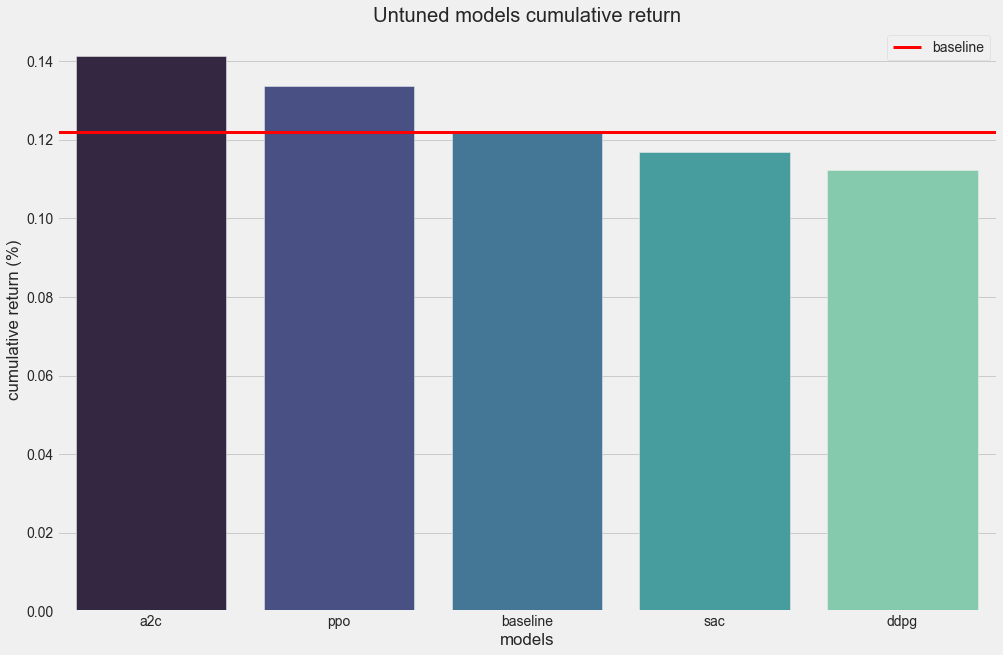

In [91]:
fig, ax = plt.subplots(figsize = (15, 10))
ax = sns.barplot(data = untuned_summary_df, 
                x = 'model', 
                y = 'cumulative_return', 
                palette = sns.color_palette('mako', n_colors=5))
ax.axhline(baseline_validation_cum_sum, linewidth = 3, color = 'r', label = 'baseline')

ax.set_title('Untuned models cumulative return')
ax.set_ylabel('cumulative return (%)')
ax.legend()
ax.set_xlabel('models');

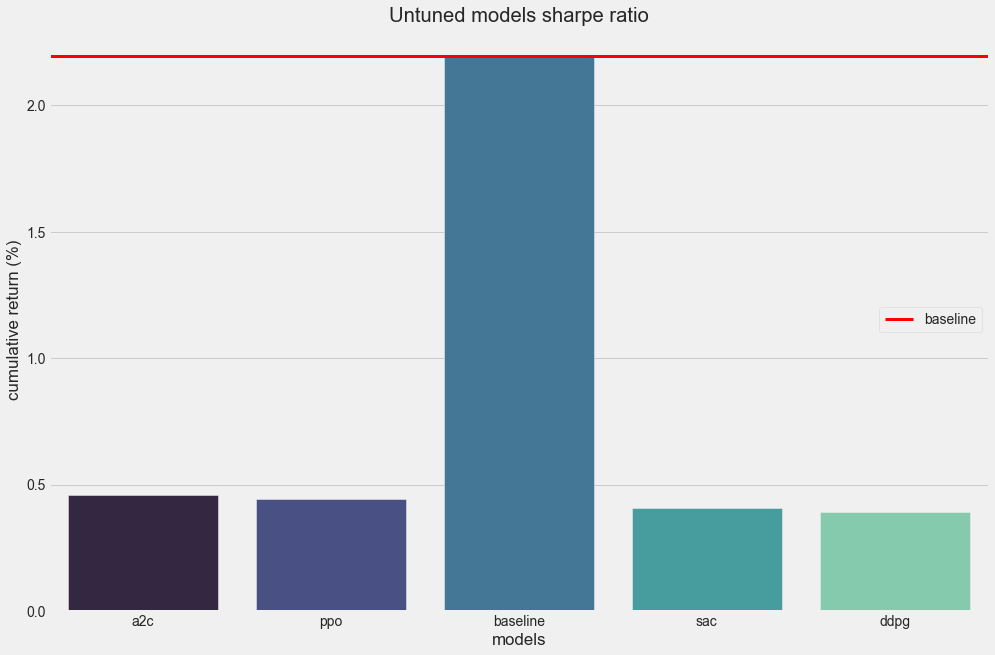

In [92]:
fig, ax = plt.subplots(figsize = (15, 10))
ax = sns.barplot(data = untuned_summary_df, 
                x = 'model', 
                y = 'sharpe_ratio', 
                palette = sns.color_palette('mako', n_colors=5))
ax.axhline(baseline_validation_sharpe_ratio, linewidth = 3, color = 'r', label = 'baseline')

ax.set_title('Untuned models sharpe ratio')
ax.set_ylabel('cumulative return (%)')
ax.legend()
ax.set_xlabel('models');

### **ANALYSIS**
Our **DDPG** model achieved the highest ROI which also beat the baseline ROI. <br><br>
However, we can see that the baseline model had a significantly better sharpe ratio. <br><br>
The sharpe ratio is a measurement of ROI / risk i.e. "how much ROI do you gain for every unit of risk that you take". <br>
### **Conclusion**
Whilst our untuned DDPG outperformed the market, it did so by taking on a significantly greater amount of risk. This model is only suited for those who are extrmely risk loving.

## **3.3 Tuned Models**
Now, we'll do some hyperparameter tuning to improve our 4 models. We'll be utilising **optuna** to do this.

The first step is to create our **objective function**. This is the value which optuna will aim to either **minimize** or **maximise**. <br>
In our case, we will be aiming to **maximise** the **sharpe ratio**. <br> <br>
As we using 4 unique algorithms, we'll need to make 4 individual objective functions. <br>
Within each function, we shall pass in the hyperparameter values that we are want to try out. 

In [87]:
import optuna

- We'll use a **sampler** to choose which of our hyperparameters should be tried. <br>
- We'll use a **pruner** to determine when to end a trial early if the results are bad.

In [88]:
sampler = optuna.samplers.TPESampler(seed = 42)
pruner = optuna.pruners.HyperbandPruner()

In [89]:
tuned_models_summary = []

In [95]:
if not os.path.exists('tuned_tensorboard_log'):
    os.makedirs('tuned_tensorboard_log')

In [126]:
def make_model(model_name, params, tensorboard_dir, train_models_dir, time_steps):
  
  agent = DRLAgent(env = env_train)
  params = params

  model = agent.get_model(model_name = model_name,
                          tensorboard_log = tensorboard_dir,
                          model_kwargs = params)
  
  trained_model = agent.train_model(model = model,
                                    tb_log_name = model_name,
                                    total_timesteps = time_steps)
  
  df_daily_return, df_actions = DRLAgent.DRL_prediction(model = trained_model, 
                                                        environment = e_trade_gym)
  
  DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
  performance_stats = timeseries.perf_stats
  performance_stats_all = performance_stats(returns = DRL_strat,
                                            factor_returns = DRL_strat,
                                            positions = None,
                                            transactions = None,
                                            turnover_denom = 'ABG')
  
  sharpe_ratio = performance_stats_all[3]
  cumulative_return = performance_stats_all[1]

  trained_model.save(f'{train_models_dir}/tuned_{model_name.upper()}.h5')

  summary_dict = {'model': model_name,
                  'daily_returns': df_daily_return,
                  'daily_actions': df_actions,
                  'sharpe_ratio': sharpe_ratio,
                  'cumulative_return': cumulative_return}
  
  return summary_dict

**A2C**

In [127]:
# defining our objective functions
def a2c_objective_function(trial):
  trial_env = env_train
  agent = DRLAgent(env=trial_env)

  params = {
            'n_steps': trial.suggest_categorical("n_steps", [8, 16, 32, 64, 128, 256, 512, 1024, 2048]),
            'ent_coef': trial.suggest_loguniform("ent_coef", 0.00000001, 0.1),
            'learning_rate': trial.suggest_loguniform("learning_rate", 1e-5, 1)      
            }

  model = agent.get_model(model_name = 'a2c',
                          tensorboard_log = 'tensorboard_log',
                          model_kwargs = params)
  
  trained_model = agent.train_model(model = model,
                                    tb_log_name = 'a2c',
                                    total_timesteps = 50000)
  
  df_daily_return, df_actions = DRLAgent.DRL_prediction(model = trained_model, 
                                                        environment = e_trade_gym)
  
  DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
  performance_stats = timeseries.perf_stats
  performance_stats_all = performance_stats(returns = DRL_strat,
                                            factor_returns = DRL_strat,
                                            positions = None,
                                            transactions = None,
                                            turnover_denom = 'ABG')
  
  sharpe_ratio = performance_stats_all[3]
  return sharpe_ratio

study_a2c = optuna.create_study(direction = 'maximize')
study_a2c.optimize(a2c_objective_function, n_trials = 20)
a2c_best_params = study_a2c.best_params

# creating our best model
tuned_a2c_summary = make_model('a2c', a2c_best_params, 'tuned_tensorboard_log', 'trained_models', 20000)
tuned_models_summary.append(tuned_a2c_summary)

[I 2022-04-02 00:52:28,939] A new study created in memory with name: no-name-fe39d842-4a9e-4568-bf73-5b636102593b


{'n_steps': 1024, 'ent_coef': 0.0009196406296445249, 'learning_rate': 0.13594461170765396}
Using cuda device
Logging to tensorboard_log\a2c_2
begin_total_asset:1000000
end_total_asset:1932635.5951137785
Sharpe:  0.9549480302817076
begin_total_asset:1000000
end_total_asset:1756396.4322102389
Sharpe:  0.8241255873374502
begin_total_asset:1000000
end_total_asset:2007449.1737379348
Sharpe:  0.9862371205314338
begin_total_asset:1000000
end_total_asset:1977209.5151259059
Sharpe:  0.9663708196541537
begin_total_asset:1000000
end_total_asset:1968014.2168894703
Sharpe:  0.9580219426155285
begin_total_asset:1000000
end_total_asset:1908191.9968308592
Sharpe:  0.9085867496451832
begin_total_asset:1000000
end_total_asset:1960526.5164269684
Sharpe:  0.9470086182179145
begin_total_asset:1000000
end_total_asset:1916454.8529528999
Sharpe:  0.9191710017816279
begin_total_asset:1000000
end_total_asset:1946503.5071070124
Sharpe:  0.9392922268107642
begin_total_asset:1000000
end_total_asset:1960240.8433056

[W 2022-04-02 00:55:56,913] Trial 0 failed because of the following error: NameError("name 'timeseries' is not defined")
Traceback (most recent call last):
  File "C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\optuna\study\_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-127-86f479ff5707>", line 24, in a2c_objective_function
    performance_stats = timeseries.perf_stats
NameError: name 'timeseries' is not defined


begin_total_asset:1000000
end_total_asset:1205693.7634381375
Sharpe:  0.5973704307918178
hit end!


NameError: name 'timeseries' is not defined

**PPO**

In [ ]:
def ppo_objective_function(trial):
  trial_env = env_train
  agent = DRLAgent(env=trial_env)

  params = {
            'n_steps': trial.suggest_categorical("n_steps", [8, 16, 32, 64, 128, 256, 512, 1024, 2048]),
            'ent_coef': trial.suggest_loguniform("ent_coef", 0.00000001, 0.1),
            'learning_rate': trial.suggest_loguniform("learning_rate", 1e-5, 1),
            'batch_size': trial.suggest_categorical("batch_size", [8, 16, 32, 64, 128, 256, 512])      
            }

  model = agent.get_model(model_name = 'ppo',
                          tensorboard_log = 'tensorboard_log',
                          model_kwargs = params)
  
  trained_model = agent.train_model(model = model,
                                    tb_log_name = 'ppo',
                                    total_timesteps = 50000)
  
  df_daily_return, df_actions = DRLAgent.DRL_prediction(model = trained_model, 
                                                        environment = e_trade_gym)
  
  DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
  performance_stats = timeseries.perf_stats
  performance_stats_all = performance_stats(returns = DRL_strat,
                                            factor_returns = DRL_strat,
                                            positions = None,
                                            transactions = None,
                                            turnover_denom = 'ABG')
  
  sharpe_ratio = performance_stats_all[3]
  return sharpe_ratio

study_ppo = optuna.create_study(direction = 'maximize')
study_ppo.optimize(ppo_objective_function, n_trials = 20)
ppo_best_params = study_ppo.best_params

# creating our best model
tuned_ppo_summary = make_model('ppo', ppo_best_params, 'tuned_tensorboard_log', 'trained_models', 20000)
tuned_models_summary.append(tuned_ppo_summary)

[I 2022-04-01 05:32:05,269] A new study created in memory with name: no-name-e8a6e20b-59ae-4e03-9e9b-28ccc293a3b7


{'n_steps': 8, 'ent_coef': 0.003791143270391488, 'learning_rate': 8.901208121009093e-05, 'batch_size': 256}
Using cpu device
Logging to tensorboard_log/ppo_1
----------------------------------
| time/              |           |
|    fps             | 206       |
|    iterations      | 1         |
|    time_elapsed    | 0         |
|    total_timesteps | 8         |
| train/             |           |
|    reward          | 1013253.4 |
----------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 97            |
|    iterations           | 2             |
|    time_elapsed         | 0             |
|    total_timesteps      | 16            |
| train/                  |               |
|    approx_kl            | 4.4703484e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -41.1         |
|    explained_variance   | -1.19e-07     |

/usr/local/lib/python3.7/dist-packages/stable_baselines3/ppo/ppo.py:141: UserWarning: You have specified a mini-batch size of 256, but because the `RolloutBuffer` is of size `n_steps * n_envs = 8`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 8
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=8 and n_envs=1)
  f"You have specified a mini-batch size of {batch_size},"


Streaming output truncated to the last 5000 lines.
|    total_timesteps      | 48008     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -41.2     |
|    explained_variance   | 0         |
|    learning_rate        | 8.9e-05   |
|    loss                 | 1.26e+13  |
|    n_updates            | 60000     |
|    policy_gradient_loss | -6.59e-06 |
|    reward               | 1159433.1 |
|    std                  | 1         |
|    value_loss           | 2.52e+13  |
---------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 75        |
|    iterations           | 6002      |
|    time_elapsed         | 633       |
|    total_timesteps      | 48016     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0

[I 2022-04-01 05:43:06,314] Trial 0 finished with value: 0.6577678798110721 and parameters: {'n_steps': 8, 'ent_coef': 0.003791143270391488, 'learning_rate': 8.901208121009093e-05, 'batch_size': 256}. Best is trial 0 with value: 0.6577678798110721.


begin_total_asset:1000000
end_total_asset:1236426.878268515
Sharpe:  0.6577678798110721
hit end!
{'n_steps': 8, 'ent_coef': 2.2643287607635404e-05, 'learning_rate': 0.7832011717215202, 'batch_size': 256}
Using cpu device
Logging to tensorboard_log/ppo_2
-----------------------------------
| time/              |            |
|    fps             | 211        |
|    iterations      | 1          |
|    time_elapsed    | 0          |
|    total_timesteps | 8          |
| train/             |            |
|    reward          | 1017093.25 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 117         |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 16          |
| train/                  |             |
|    approx_kl            | 0.102857016 |
|    clip_fraction        | 0.5         |
|    clip_range           | 0.2         |
| 

/usr/local/lib/python3.7/dist-packages/stable_baselines3/ppo/ppo.py:141: UserWarning: You have specified a mini-batch size of 256, but because the `RolloutBuffer` is of size `n_steps * n_envs = 8`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 8
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=8 and n_envs=1)
  f"You have specified a mini-batch size of {batch_size},"


Streaming output truncated to the last 5000 lines.
|    total_timesteps      | 48008      |
| train/                  |            |
|    approx_kl            | 0.18648814 |
|    clip_fraction        | 0.512      |
|    clip_range           | 0.2        |
|    entropy_loss         | -37        |
|    explained_variance   | 1.19e-07   |
|    learning_rate        | 0.783      |
|    loss                 | 1.18e+13   |
|    n_updates            | 60000      |
|    policy_gradient_loss | -0.111     |
|    reward               | 1154570.9  |
|    std                  | 0.886      |
|    value_loss           | 2.37e+13   |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 72         |
|    iterations           | 6002       |
|    time_elapsed         | 659        |
|    total_timesteps      | 48016      |
| train/                  |            |
|    approx_kl            | 0.23865989 |
|    c

[I 2022-04-01 05:54:34,640] Trial 1 finished with value: 0.6928603879452736 and parameters: {'n_steps': 8, 'ent_coef': 2.2643287607635404e-05, 'learning_rate': 0.7832011717215202, 'batch_size': 256}. Best is trial 1 with value: 0.6928603879452736.


begin_total_asset:1000000
end_total_asset:1255448.3357611513
Sharpe:  0.6928603879452737
hit end!
{'n_steps': 128, 'ent_coef': 2.9715284580596563e-08, 'learning_rate': 0.016063601942228316, 'batch_size': 512}
Using cpu device
Logging to tensorboard_log/ppo_3


/usr/local/lib/python3.7/dist-packages/stable_baselines3/ppo/ppo.py:141: UserWarning: You have specified a mini-batch size of 512, but because the `RolloutBuffer` is of size `n_steps * n_envs = 128`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 128
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=128 and n_envs=1)
  f"You have specified a mini-batch size of {batch_size},"


Streaming output truncated to the last 5000 lines.
|    total_timesteps      | 18816        |
| train/                  |              |
|    approx_kl            | 3.678724e-08 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -41.1        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0161       |
|    loss                 | 4.14e+14     |
|    n_updates            | 1460         |
|    policy_gradient_loss | -2.69e-05    |
|    reward               | 1000315.4    |
|    std                  | 1            |
|    value_loss           | 8.29e+14     |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 234         |
|    iterations           | 148         |
|    time_elapsed         | 80          |
|    total_timesteps      | 18944       |
| train/                  |             |
|    appro

[I 2022-04-01 05:58:10,330] Trial 2 finished with value: 0.6582639140987621 and parameters: {'n_steps': 128, 'ent_coef': 2.9715284580596563e-08, 'learning_rate': 0.016063601942228316, 'batch_size': 512}. Best is trial 1 with value: 0.6928603879452736.


begin_total_asset:1000000
end_total_asset:1236688.4630523152
Sharpe:  0.6582639140987621
hit end!
{'n_steps': 1024, 'ent_coef': 0.016057952251567233, 'learning_rate': 0.003150197999365856, 'batch_size': 64}
Using cpu device
Logging to tensorboard_log/ppo_4
----------------------------------
| time/              |           |
|    fps             | 311       |
|    iterations      | 1         |
|    time_elapsed    | 3         |
|    total_timesteps | 1024      |
| train/             |           |
|    reward          | 1626748.9 |
----------------------------------
begin_total_asset:1000000
end_total_asset:1876517.4897901043
Sharpe:  0.9087685749628114
-------------------------------------------
| time/                   |               |
|    fps                  | 250           |
|    iterations           | 2             |
|    time_elapsed         | 8             |
|    total_timesteps      | 2048          |
| train/                  |               |
|    approx_kl            | 2.4

[I 2022-04-01 06:02:03,527] Trial 3 finished with value: 0.6580766034131709 and parameters: {'n_steps': 1024, 'ent_coef': 0.016057952251567233, 'learning_rate': 0.003150197999365856, 'batch_size': 64}. Best is trial 1 with value: 0.6928603879452736.


begin_total_asset:1000000
end_total_asset:1236591.3480698282
Sharpe:  0.6580766034131709
hit end!
{'n_steps': 512, 'ent_coef': 0.00013251820132451945, 'learning_rate': 0.1373103945730866, 'batch_size': 64}
Using cpu device
Logging to tensorboard_log/ppo_5
----------------------------------
| time/              |           |
|    fps             | 310       |
|    iterations      | 1         |
|    time_elapsed    | 1         |
|    total_timesteps | 512       |
| train/             |           |
|    reward          | 1344072.0 |
----------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 263           |
|    iterations           | 2             |
|    time_elapsed         | 3             |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 0.00020344218 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2  

[I 2022-04-01 06:05:59,615] Trial 4 finished with value: 0.6577896892998065 and parameters: {'n_steps': 512, 'ent_coef': 0.00013251820132451945, 'learning_rate': 0.1373103945730866, 'batch_size': 64}. Best is trial 1 with value: 0.6928603879452736.


Streaming output truncated to the last 5000 lines.
|    total_timesteps      | 42080        |
| train/                  |              |
|    approx_kl            | 4.838966e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -41.2        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0273       |
|    loss                 | 4.24e+13     |
|    n_updates            | 13140        |
|    policy_gradient_loss | -0.00284     |
|    reward               | 1084277.6    |
|    std                  | 1            |
|    value_loss           | 1.2e+14      |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 120           |
|    iterations           | 1316          |
|    time_elapsed         | 350           |
|    total_timesteps      | 42112         |
| train/                  |             

[I 2022-04-01 06:12:58,185] Trial 5 finished with value: 0.6584553952408512 and parameters: {'n_steps': 32, 'ent_coef': 9.944619267742852e-05, 'learning_rate': 0.02726386789067451, 'batch_size': 16}. Best is trial 1 with value: 0.6928603879452736.


Streaming output truncated to the last 5000 lines.
|    policy_gradient_loss | -0.0087      |
|    reward               | 1552383.9    |
|    std                  | 1            |
|    value_loss           | 3.83e+14     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 198          |
|    iterations           | 536          |
|    time_elapsed         | 172          |
|    total_timesteps      | 34304        |
| train/                  |              |
|    approx_kl            | 0.0010602474 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -41.2        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.795        |
|    loss                 | 2.04e+14     |
|    n_updates            | 5350         |
|    policy_gradient_loss | -0.00903     |
|    reward               | 1637568.8    |
|  

[I 2022-04-01 06:17:11,039] Trial 6 finished with value: 0.6424293938401198 and parameters: {'n_steps': 64, 'ent_coef': 7.890346809001433e-06, 'learning_rate': 0.7951489435468322, 'batch_size': 64}. Best is trial 1 with value: 0.6928603879452736.


begin_total_asset:1000000
end_total_asset:1231617.0114801645
Sharpe:  0.6424293938401199
hit end!
{'n_steps': 1024, 'ent_coef': 3.7154990355317645e-07, 'learning_rate': 0.0006343244134051302, 'batch_size': 512}
Using cpu device
Logging to tensorboard_log/ppo_8
----------------------------------
| time/              |           |
|    fps             | 306       |
|    iterations      | 1         |
|    time_elapsed    | 3         |
|    total_timesteps | 1024      |
| train/             |           |
|    reward          | 1630746.4 |
----------------------------------
begin_total_asset:1000000
end_total_asset:1893335.6906864068
Sharpe:  0.9204095805497057
---------------------------------------
| time/                   |           |
|    fps                  | 282       |
|    iterations           | 2         |
|    time_elapsed         | 7         |
|    total_timesteps      | 2048      |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fract

[I 2022-04-01 06:20:26,053] Trial 7 finished with value: 0.6582375764100674 and parameters: {'n_steps': 1024, 'ent_coef': 3.7154990355317645e-07, 'learning_rate': 0.0006343244134051302, 'batch_size': 512}. Best is trial 1 with value: 0.6928603879452736.


begin_total_asset:1000000
end_total_asset:1236657.4315503049
Sharpe:  0.6582375764100674
hit end!
{'n_steps': 64, 'ent_coef': 5.0819392720912606e-08, 'learning_rate': 0.0001933508690753184, 'batch_size': 512}
Using cpu device
Logging to tensorboard_log/ppo_9


/usr/local/lib/python3.7/dist-packages/stable_baselines3/ppo/ppo.py:141: UserWarning: You have specified a mini-batch size of 512, but because the `RolloutBuffer` is of size `n_steps * n_envs = 64`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 64
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=64 and n_envs=1)
  f"You have specified a mini-batch size of {batch_size},"


Streaming output truncated to the last 5000 lines.
|    policy_gradient_loss | -4.61e-07 |
|    reward               | 1525925.2 |
|    std                  | 1         |
|    value_loss           | 3.65e+14  |
---------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 198       |
|    iterations           | 536       |
|    time_elapsed         | 172       |
|    total_timesteps      | 34304     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -41.1     |
|    explained_variance   | 0         |
|    learning_rate        | 0.000193  |
|    loss                 | 1.99e+14  |
|    n_updates            | 5350      |
|    policy_gradient_loss | -1.69e-06 |
|    reward               | 1620416.1 |
|    std                  | 1         |
|    value_loss           | 3

[I 2022-04-01 06:24:39,690] Trial 8 finished with value: 0.6579454320159158 and parameters: {'n_steps': 64, 'ent_coef': 5.0819392720912606e-08, 'learning_rate': 0.0001933508690753184, 'batch_size': 512}. Best is trial 1 with value: 0.6928603879452736.


begin_total_asset:1000000
end_total_asset:1236472.2777018445
Sharpe:  0.6579454320159158
hit end!
{'n_steps': 512, 'ent_coef': 2.060222273889813e-07, 'learning_rate': 0.3000025530214645, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo_10
----------------------------------
| time/              |           |
|    fps             | 312       |
|    iterations      | 1         |
|    time_elapsed    | 1         |
|    total_timesteps | 512       |
| train/             |           |
|    reward          | 1367992.5 |
----------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 277           |
|    iterations           | 2             |
|    time_elapsed         | 3             |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 0.00026441016 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2 

[I 2022-04-01 06:28:13,555] Trial 9 finished with value: 0.6613883349020011 and parameters: {'n_steps': 512, 'ent_coef': 2.060222273889813e-07, 'learning_rate': 0.3000025530214645, 'batch_size': 128}. Best is trial 1 with value: 0.6928603879452736.


begin_total_asset:1000000
end_total_asset:1238125.2435170352
Sharpe:  0.6613883349020011
hit end!
{'n_steps': 16, 'ent_coef': 7.336375926753379e-06, 'learning_rate': 1.6136646728984015e-05, 'batch_size': 32}
Using cpu device
Logging to tensorboard_log/ppo_11
----------------------------------
| time/              |           |
|    fps             | 216       |
|    iterations      | 1         |
|    time_elapsed    | 0         |
|    total_timesteps | 16        |
| train/             |           |
|    reward          | 1009303.8 |
----------------------------------


/usr/local/lib/python3.7/dist-packages/stable_baselines3/ppo/ppo.py:141: UserWarning: You have specified a mini-batch size of 32, but because the `RolloutBuffer` is of size `n_steps * n_envs = 16`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 16
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=16 and n_envs=1)
  f"You have specified a mini-batch size of {batch_size},"


Streaming output truncated to the last 5000 lines.
|    policy_gradient_loss | -8.83e-07 |
|    reward               | 1753776.8 |
|    std                  | 1         |
|    value_loss           | 1.41e+14  |
---------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 109       |
|    iterations           | 2877      |
|    time_elapsed         | 419       |
|    total_timesteps      | 46032     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -41.1     |
|    explained_variance   | 0         |
|    learning_rate        | 1.61e-05  |
|    loss                 | 7.51e+13  |
|    n_updates            | 28760     |
|    policy_gradient_loss | -1.31e-06 |
|    reward               | 1789270.9 |
|    std                  | 1         |
|    value_loss           | 1

[I 2022-04-01 06:35:50,054] Trial 10 finished with value: 0.6586724370619202 and parameters: {'n_steps': 16, 'ent_coef': 7.336375926753379e-06, 'learning_rate': 1.6136646728984015e-05, 'batch_size': 32}. Best is trial 1 with value: 0.6928603879452736.


begin_total_asset:1000000
end_total_asset:1236870.501008976
Sharpe:  0.6586724370619202
hit end!
{'n_steps': 512, 'ent_coef': 8.035751945965537e-07, 'learning_rate': 0.9497707172339702, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo_12
----------------------------------
| time/              |           |
|    fps             | 296       |
|    iterations      | 1         |
|    time_elapsed    | 1         |
|    total_timesteps | 512       |
| train/             |           |
|    reward          | 1371185.5 |
----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 273         |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.002289989 |
|    clip_fraction        | 0.000781    |
|    clip_range           | 0.2         |
|    entr

[I 2022-04-01 06:39:21,746] Trial 11 finished with value: 0.6605750011834013 and parameters: {'n_steps': 512, 'ent_coef': 8.035751945965537e-07, 'learning_rate': 0.9497707172339702, 'batch_size': 128}. Best is trial 1 with value: 0.6928603879452736.


begin_total_asset:1000000
end_total_asset:1237192.02184064
Sharpe:  0.6605750011834013
hit end!
{'n_steps': 8, 'ent_coef': 0.00043591268772096454, 'learning_rate': 0.12140611197742773, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo_13
-----------------------------------
| time/              |            |
|    fps             | 133        |
|    iterations      | 1          |
|    time_elapsed    | 0          |
|    total_timesteps | 8          |
| train/             |            |
|    reward          | 1014360.25 |
-----------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 91         |
|    iterations           | 2          |
|    time_elapsed         | 0          |
|    total_timesteps      | 16         |
| train/                  |            |
|    approx_kl            | 0.03612563 |
|    clip_fraction        | 0.338      |
|    clip_range           | 0.2        |
|    entrop

/usr/local/lib/python3.7/dist-packages/stable_baselines3/ppo/ppo.py:141: UserWarning: You have specified a mini-batch size of 128, but because the `RolloutBuffer` is of size `n_steps * n_envs = 8`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 8
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=8 and n_envs=1)
  f"You have specified a mini-batch size of {batch_size},"


Streaming output truncated to the last 5000 lines.
|    total_timesteps      | 48008       |
| train/                  |             |
|    approx_kl            | 0.006089486 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -40.9       |
|    explained_variance   | 0           |
|    learning_rate        | 0.121       |
|    loss                 | 1.32e+13    |
|    n_updates            | 60000       |
|    policy_gradient_loss | -0.0318     |
|    reward               | 1187963.2   |
|    std                  | 0.991       |
|    value_loss           | 2.64e+13    |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 67           |
|    iterations           | 6002         |
|    time_elapsed         | 712          |
|    total_timesteps      | 48016        |
| train/                  |              |
|    approx_kl    

[I 2022-04-01 06:51:45,097] Trial 12 finished with value: 0.6476913994710021 and parameters: {'n_steps': 8, 'ent_coef': 0.00043591268772096454, 'learning_rate': 0.12140611197742773, 'batch_size': 128}. Best is trial 1 with value: 0.6928603879452736.


begin_total_asset:1000000
end_total_asset:1228447.7985176037
Sharpe:  0.6476913994710021
hit end!
{'n_steps': 2048, 'ent_coef': 1.07301395176391e-06, 'learning_rate': 0.24125382797892755, 'batch_size': 8}
Using cpu device
Logging to tensorboard_log/ppo_14
begin_total_asset:1000000
end_total_asset:1824478.2063366082
Sharpe:  0.8713742792326299
----------------------------------
| time/              |           |
|    fps             | 289       |
|    iterations      | 1         |
|    time_elapsed    | 7         |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 1358684.1 |
----------------------------------
begin_total_asset:1000000
end_total_asset:1923449.2896393356
Sharpe:  0.9416186020395227
------------------------------------------
| time/                   |              |
|    fps                  | 133          |
|    iterations           | 2            |
|    time_elapsed         | 30           |
|    total_timesteps      | 4096    

[I 2022-04-01 07:01:44,414] Trial 13 finished with value: 0.6555408766657042 and parameters: {'n_steps': 2048, 'ent_coef': 1.07301395176391e-06, 'learning_rate': 0.24125382797892755, 'batch_size': 8}. Best is trial 1 with value: 0.6928603879452736.


begin_total_asset:1000000
end_total_asset:1235223.5282950313
Sharpe:  0.6555408766657042
hit end!
{'n_steps': 256, 'ent_coef': 7.6271847922049425e-06, 'learning_rate': 0.01764147837421115, 'batch_size': 256}
Using cpu device
Logging to tensorboard_log/ppo_15
----------------------------------
| time/              |           |
|    fps             | 285       |
|    iterations      | 1         |
|    time_elapsed    | 0         |
|    total_timesteps | 256       |
| train/             |           |
|    reward          | 1189962.9 |
----------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 275           |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 512           |
| train/                  |               |
|    approx_kl            | 1.7997809e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.

[I 2022-04-01 07:05:07,130] Trial 14 finished with value: 0.658281482195221 and parameters: {'n_steps': 256, 'ent_coef': 7.6271847922049425e-06, 'learning_rate': 0.01764147837421115, 'batch_size': 256}. Best is trial 1 with value: 0.6928603879452736.


begin_total_asset:1000000
end_total_asset:1236646.0051388019
Sharpe:  0.658281482195221
hit end!
{'n_steps': 8, 'ent_coef': 0.0010158205922860188, 'learning_rate': 0.05894410893434583, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo_16
----------------------------------
| time/              |           |
|    fps             | 138       |
|    iterations      | 1         |
|    time_elapsed    | 0         |
|    total_timesteps | 8         |
| train/             |           |
|    reward          | 1014580.0 |
----------------------------------


/usr/local/lib/python3.7/dist-packages/stable_baselines3/ppo/ppo.py:141: UserWarning: You have specified a mini-batch size of 128, but because the `RolloutBuffer` is of size `n_steps * n_envs = 8`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 8
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=8 and n_envs=1)
  f"You have specified a mini-batch size of {batch_size},"


Streaming output truncated to the last 5000 lines.
|    total_timesteps      | 48008        |
| train/                  |              |
|    approx_kl            | 0.0018319637 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -41.4        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0589       |
|    loss                 | 1.27e+13     |
|    n_updates            | 60000        |
|    policy_gradient_loss | -0.0223      |
|    reward               | 1166506.5    |
|    std                  | 1.01         |
|    value_loss           | 2.55e+13     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 66           |
|    iterations           | 6002         |
|    time_elapsed         | 723          |
|    total_timesteps      | 48016        |
| train/                  |              |
|  

[I 2022-04-01 07:17:41,840] Trial 15 finished with value: 0.6527764890176786 and parameters: {'n_steps': 8, 'ent_coef': 0.0010158205922860188, 'learning_rate': 0.05894410893434583, 'batch_size': 128}. Best is trial 1 with value: 0.6928603879452736.


begin_total_asset:1000000
end_total_asset:1238350.2448714369
Sharpe:  0.6527764890176786
hit end!
{'n_steps': 512, 'ent_coef': 1.208866092924395e-07, 'learning_rate': 0.005479473943460083, 'batch_size': 256}
Using cpu device
Logging to tensorboard_log/ppo_17
----------------------------------
| time/              |           |
|    fps             | 303       |
|    iterations      | 1         |
|    time_elapsed    | 1         |
|    total_timesteps | 512       |
| train/             |           |
|    reward          | 1326346.6 |
----------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 288           |
|    iterations           | 2             |
|    time_elapsed         | 3             |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 2.4680048e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.

[I 2022-04-01 07:21:01,637] Trial 16 finished with value: 0.657575808174538 and parameters: {'n_steps': 512, 'ent_coef': 1.208866092924395e-07, 'learning_rate': 0.005479473943460083, 'batch_size': 256}. Best is trial 1 with value: 0.6928603879452736.


Streaming output truncated to the last 5000 lines.
|    total_timesteps      | 18816       |
| train/                  |             |
|    approx_kl            | 0.005219206 |
|    clip_fraction        | 0.0125      |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0           |
|    learning_rate        | 0.277       |
|    loss                 | 3.29e+14    |
|    n_updates            | 1460        |
|    policy_gradient_loss | -0.0175     |
|    reward               | 1001107.5   |
|    std                  | 1           |
|    value_loss           | 7.85e+14    |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 84           |
|    iterations           | 148          |
|    time_elapsed         | 224          |
|    total_timesteps      | 18944        |
| train/                  |              |
|    approx_kl    

[I 2022-04-01 07:31:00,045] Trial 17 finished with value: 0.6557257637177287 and parameters: {'n_steps': 128, 'ent_coef': 2.1059943178422814e-05, 'learning_rate': 0.2770926760247823, 'batch_size': 8}. Best is trial 1 with value: 0.6928603879452736.


begin_total_asset:1000000
end_total_asset:1232236.9863758588
Sharpe:  0.6557257637177286
hit end!
{'n_steps': 256, 'ent_coef': 0.08869633063449463, 'learning_rate': 0.9529712110477975, 'batch_size': 32}
Using cpu device
Logging to tensorboard_log/ppo_19
----------------------------------
| time/              |           |
|    fps             | 296       |
|    iterations      | 1         |
|    time_elapsed    | 0         |
|    total_timesteps | 256       |
| train/             |           |
|    reward          | 1173737.5 |
----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 213         |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 512         |
| train/                  |             |
|    approx_kl            | 0.012227323 |
|    clip_fraction        | 0.0965      |
|    clip_range           | 0.2         |
|    entrop

[I 2022-04-01 07:35:51,367] Trial 18 finished with value: 0.6342405687810947 and parameters: {'n_steps': 256, 'ent_coef': 0.08869633063449463, 'learning_rate': 0.9529712110477975, 'batch_size': 32}. Best is trial 1 with value: 0.6928603879452736.


Streaming output truncated to the last 5000 lines.
|    total_timesteps      | 42080        |
| train/                  |              |
|    approx_kl            | 3.017485e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -41.1        |
|    explained_variance   | 0            |
|    learning_rate        | 0.00332      |
|    loss                 | 6.26e+13     |
|    n_updates            | 13140        |
|    policy_gradient_loss | -0.000192    |
|    reward               | 1090785.2    |
|    std                  | 1            |
|    value_loss           | 1.23e+14     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 115          |
|    iterations           | 1316         |
|    time_elapsed         | 363          |
|    total_timesteps      | 42112        |
| train/                  |              |
|  

[I 2022-04-01 07:43:05,713] Trial 19 finished with value: 0.65791248130907 and parameters: {'n_steps': 32, 'ent_coef': 1.2449616834276893e-08, 'learning_rate': 0.003319986809403031, 'batch_size': 16}. Best is trial 1 with value: 0.6928603879452736.


begin_total_asset:1000000
end_total_asset:1236411.9657066222
Sharpe:  0.65791248130907
hit end!
{'n_steps': 8, 'ent_coef': 2.2643287607635404e-05, 'learning_rate': 0.7832011717215202, 'batch_size': 256}
Using cpu device
Logging to tuned_tensorboard_log/ppo_1
-----------------------------------
| time/              |            |
|    fps             | 122        |
|    iterations      | 1          |
|    time_elapsed    | 0          |
|    total_timesteps | 8          |
| train/             |            |
|    reward          | 1018535.56 |
-----------------------------------


/usr/local/lib/python3.7/dist-packages/stable_baselines3/ppo/ppo.py:141: UserWarning: You have specified a mini-batch size of 256, but because the `RolloutBuffer` is of size `n_steps * n_envs = 8`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 8
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=8 and n_envs=1)
  f"You have specified a mini-batch size of {batch_size},"


Streaming output truncated to the last 5000 lines.
|    explained_variance   | 0           |
|    learning_rate        | 0.783       |
|    loss                 | 1.47e+13    |
|    n_updates            | 22500       |
|    policy_gradient_loss | -0.101      |
|    reward               | 1302356.6   |
|    std                  | 0.967       |
|    value_loss           | 2.95e+13    |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 61         |
|    iterations           | 2252       |
|    time_elapsed         | 291        |
|    total_timesteps      | 18016      |
| train/                  |            |
|    approx_kl            | 0.12084084 |
|    clip_fraction        | 0.4        |
|    clip_range           | 0.2        |
|    entropy_loss         | -40        |
|    explained_variance   | 0          |
|    learning_rate        | 0.783      |
|    loss                 | 1.55e+13  

**DDPG**

In [ ]:
def ddpg_objective_function(trial):
  trial_env = env_train
  agent = DRLAgent(env=trial_env)

  params = {
            'buffer_size':  trial.suggest_categorical("buffer_size", [int(1e4), int(1e5), int(1e6)]),
            'learning_rate': trial.suggest_loguniform("learning_rate", 1e-5, 1),
            'batch_size': trial.suggest_categorical("batch_size", [8, 16, 32, 64, 128, 256, 512])      
            }

  model = agent.get_model(model_name = 'ddpg',
                          tensorboard_log = 'tensorboard_log',
                          model_kwargs = params)
  
  trained_model = agent.train_model(model = model,
                                    tb_log_name = 'ddpg',
                                    total_timesteps = 50000)
  
  df_daily_return, df_actions = DRLAgent.DRL_prediction(model = trained_model, 
                                                        environment = e_trade_gym)
  
  DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
  performance_stats = timeseries.perf_stats
  performance_stats_all = performance_stats(returns = DRL_strat,
                                            factor_returns = DRL_strat,
                                            positions = None,
                                            transactions = None,
                                            turnover_denom = 'ABG')
  
  sharpe_ratio = performance_stats_all[3]
  return sharpe_ratio

study_ddpg = optuna.create_study(direction = 'maximize')
study_ddpg.optimize(ddpg_objective_function, n_trials = 20)
ddpg_best_params = study_ddpg.best_params

# creating our best model
tuned_ddpg_summary = make_model('ddpg', ddpg_best_params, 'tuned_tensorboard_log', 'trained_models', 20000)
tuned_models_summary.append(tuned_ddpg_summary)

[I 2022-04-01 07:48:30,119] A new study created in memory with name: no-name-53fcee32-a58e-4fec-8f7d-b7786051866c


{'buffer_size': 10000, 'learning_rate': 2.0787222446006676e-05, 'batch_size': 512}
Using cpu device
Logging to tensorboard_log/ddpg_1
begin_total_asset:1000000
end_total_asset:2004657.2360774435
Sharpe:  1.0013832945033923
begin_total_asset:1000000
end_total_asset:2004334.1395860736
Sharpe:  1.001236870555199
begin_total_asset:1000000
end_total_asset:2004334.1395860736
Sharpe:  1.001236870555199
begin_total_asset:1000000
end_total_asset:2004334.1395860736
Sharpe:  1.001236870555199
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 8         |
|    time_elapsed    | 656       |
|    total_timesteps | 5788      |
| train/             |           |
|    actor_loss      | -3.33e+06 |
|    critic_loss     | 2.18e+11  |
|    learning_rate   | 2.08e-05  |
|    n_updates       | 4341      |
|    reward          | 2004334.1 |
----------------------------------
begin_total_asset:1000000
end_total_asset:2004334.13958607

**SAC**

In [ ]:
def sac_objective_function(trial):
  trial_env = env_train
  agent = DRLAgent(env=trial_env)

  params = {
            'buffer_size':  trial.suggest_categorical("buffer_size", [int(1e4), int(1e5), int(1e6)]),
            'learning_rate': trial.suggest_loguniform("learning_rate", 1e-5, 1),
            'batch_size': trial.suggest_categorical("batch_size", [8, 16, 32, 64, 128, 256, 512]),
            'learning_starts': trial.suggest_categorical("learning_starts", [0, 1000, 10000, 20000])  
            }

  model = agent.get_model(model_name = 'sac',
                          tensorboard_log = 'tensorboard_log',
                          model_kwargs = params)
  
  trained_model = agent.train_model(model = model,
                                    tb_log_name = 'sac',
                                    total_timesteps = 50000)
  
  df_daily_return, df_actions = DRLAgent.DRL_prediction(model = trained_model, 
                                                        environment = e_trade_gym)
  
  DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
  performance_stats = timeseries.perf_stats
  performance_stats_all = performance_stats(returns = DRL_strat,
                                            factor_returns = DRL_strat,
                                            positions = None,
                                            transactions = None,
                                            turnover_denom = 'ABG')
  
  sharpe_ratio = performance_stats_all[3]
  return sharpe_ratio

study_sac = optuna.create_study(direction = 'maximize')
study_sac.optimize(sac_objective_function, n_trials = 20)
sac_best_params = study_sac.best_params

# creating our best model
tuned_sac_summary = make_model('sac', sac_best_params, 'tuned_tensorboard_log', 'trained_models', 20000)
tuned_models_summary.append(tuned_sac_summary)

In [ ]:
tuned_models_summary.append({
                             'model': 'baseline',
                             'cumulative_return': baseline_validation_cum_sum,
                             'sharpe_ratio': baseline_validation_sharpe_ratio
})

with open('data/tuned_summary.pickle', 'wb') as handle:
  pickle.dump(tuned_models_summary, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [108]:
df_daily_return

date  daily_return
0    2019-01-29      0.000000
1    2019-01-30      0.015303
2    2019-01-31      0.005360
3    2019-02-01      0.003918
4    2019-02-04      0.008603
..          ...           ...
357  2020-06-29      0.021414
358  2020-06-30      0.008986
359  2020-07-01      0.000946
360  2020-07-02      0.004045
361  2020-07-06      0.015581

[362 rows x 2 columns]

In [157]:
dow_index = yf.download('^DJI', period='5y')

[*********************100%***********************]  1 of 1 completed


In [158]:
dow_index = dow_index.reset_index()

In [159]:
dow_index = dow_index[(dow_index['Date'] > '2019-01-29') & (dow_index['Date'] < '2020-06-29')]

In [160]:
dow_index['Date'] = dow_index['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))

In [161]:
dow_index['ROI'] = dow_index['Adj Close'].pct_change()

In [162]:
dow_index = dow_index.rename({'ROI': 'market_return', 'Date': 'date'}, axis = 1)

In [163]:
dow_index

date          Open          High           Low         Close  \
440  2019-01-30  24826.519531  25109.619141  24790.900391  25014.859375   
441  2019-01-31  24954.480469  25049.619141  24842.089844  24999.669922   
442  2019-02-01  25025.310547  25193.150391  24982.490234  25063.890625   
443  2019-02-04  25062.119141  25239.910156  24977.669922  25239.369141   
444  2019-02-05  25287.929688  25427.320312  25287.650391  25411.519531   
..          ...           ...           ...           ...           ...   
791  2020-06-22  25865.080078  26059.810547  25667.679688  26024.960938   
792  2020-06-23  26159.390625  26314.970703  26105.970703  26156.099609   
793  2020-06-24  25992.960938  25992.960938  25296.730469  25445.939453   
794  2020-06-25  25365.220703  25769.609375  25209.789062  25745.599609   
795  2020-06-26  25641.689453  25641.689453  24971.029297  25015.550781   

        Adj Close     Volume  market_return  
440  25014.859375  397330000            NaN  
441  24999.669922  507350000      -0.000607  
442  25063.890625  372090000       0.002569  
443  25239.369141  298540000       0.007001  
444  25411.519531  310650000       0.006821  
..            ...        ...            ...  
791  26024.960938  351780000       0.005933  
792  26156.099609  389980000       0.005039  
793  25445.939453  450120000      -0.027151  
794  25745.599609  384560000       0.011776  
795  25015.550781  640860000      -0.028356  

[356 rows x 8 columns]

In [278]:
a_new_df = dow_index[['market_return', 'date']].merge(df_daily_return)
a_new_df = a_new_df[['date', 'daily_return', 'market_return']]

In [270]:
a_new_df

date  daily_return  market_return
0    2019-01-30      0.015303            NaN
1    2019-01-31      0.005360      -0.000607
2    2019-02-01      0.003918       0.002569
3    2019-02-04      0.008603       0.007001
4    2019-02-05      0.006397       0.006821
..          ...           ...            ...
351  2020-06-22      0.004116       0.005933
352  2020-06-23      0.002628       0.005039
353  2020-06-24     -0.026576      -0.027151
354  2020-06-25      0.012189       0.011776
355  2020-06-26     -0.026201      -0.028356

[356 rows x 3 columns]

In [262]:
from decimal import Decimal

In [279]:
a_new_df['daily_return'] = a_new_df['daily_return'].apply(lambda x: float(Decimal(x).quantize(Decimal('0.0001')) * 100))
a_new_df['market_return'] = a_new_df['market_return'].apply(lambda x: float(Decimal(x).quantize(Decimal('0.0001')) * 100))

In [272]:
a_new_df

date  daily_return  market_return
0    2019-01-30          1.53            NaN
1    2019-01-31          0.54          -0.06
2    2019-02-01          0.39           0.26
3    2019-02-04          0.86           0.70
4    2019-02-05          0.64           0.68
..          ...           ...            ...
351  2020-06-22          0.41           0.59
352  2020-06-23          0.26           0.50
353  2020-06-24         -2.66          -2.72
354  2020-06-25          1.22           1.18
355  2020-06-26         -2.62          -2.84

[356 rows x 3 columns]

In [280]:
a_new_df['model_gain/loss'] = a_new_df['daily_return'] - a_new_df['market_return']

In [285]:
a_new_df['model_gain/loss'].apply(lambda x: str(float(Decimal(x).quantize(Decimal('0.0001')))) + '%')

0        nan%
1        0.6%
2       0.13%
3       0.16%
4      -0.04%
        ...  
351    -0.18%
352    -0.24%
353     0.06%
354     0.04%
355     0.22%
Name: model_gain/loss, Length: 356, dtype: object

In [203]:
import plotly.express as px

In [243]:
fig = px.line(
    a_new_df,
    x = 'date',
    y = ['daily_return', 'market_return'],
    hover_data = ['model_gain/loss']
)
fig.update_layout(title_text = f'Model vs Market')
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="ROI (%)")

In [300]:
b_new_df

Name  Cum_Sum
0   Model    12.42
1  Market     6.67

In [299]:
b_new_df = pd.DataFrame([
    {
        'Name': 'Model',
        'Cum_Sum': round(a_new_df['daily_return'].sum(), 4),
    },
    {
        'Name': 'Market',
        'Cum_Sum': round(a_new_df['market_return'].sum(), 4)
    }
    ])

In [302]:
fig = px.bar(
    b_new_df,
    x = 'Name',
    y = 'Cum_Sum',
)
fig.update_layout(title_text = f'Model vs Market')
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="ROI (%)")